In [1]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline


from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity#?

from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


In [2]:
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/bge-m3-zeroshot-v2.0", use_safetensors=False) 
print('classifier loaded!')


Device set to use cpu


classifier loaded!


In [21]:
def labeliser(df,labels):
  sp=df.host_about
  res_df=pd.DataFrame()

  for i, sp in enumerate(sp):#test
    output = classifier(sp, labels, multi_label=True)

    res_courant={'sp':sp}
    labels_scores=dict(zip(output['labels'],output['scores']))
    for lab in labels :
      if lab not in res_courant:
        res_courant[lab]=labels_scores[lab]
    res_courant=pd.DataFrame(res_courant, index=[i])
    res_df=pd.concat([res_df,res_courant])

  return res_df

In [4]:
listings_fr=pd.read_csv('D:/Master_ENC/mini_memoire/data_sepa_par_langue/listings_fr_unique.csv', sep=",", on_bad_lines="skip", encoding='utf-8')
print('len de listings_fr:', len(listings_fr))
print(listings_fr.head())

len de listings_fr: 12052
       id                          listing_url       scrape_id last_scraped  \
0    9952    https://www.airbnb.com/rooms/9952  20231212042736   2023-12-14   
1   87481   https://www.airbnb.com/rooms/87481  20231212042736   2023-12-13   
2   12452   https://www.airbnb.com/rooms/12452  20231212042736   2023-12-13   
3   98322   https://www.airbnb.com/rooms/98322  20231212042736   2023-12-13   
4  105210  https://www.airbnb.com/rooms/105210  20231212042736   2023-12-14   

        source                                               name  \
0  city scrape  Rental unit in Paris · ★4.92 · 1 bedroom · 1 b...   
1  city scrape  Rental unit in Paris · ★4.91 · 1 bedroom · 1 b...   
2  city scrape  Rental unit in Paris 11e Arrondissement · ★4.8...   
3  city scrape  Rental unit in Paris · ★4.92 · 2 bedrooms · 2 ...   
4  city scrape  Rental unit in Paris · ★4.86 · 1 bedroom · 1 b...   

   description                              neighborhood_overview  \
0          NaN 

In [5]:
res_fr=pd.read_csv("D:\Master_ENC\mini_memoire/res_tactiques2//result_fr3.csv", sep=",", on_bad_lines="skip", encoding='utf-8')
print(res_fr.columns)

Index(['sp', 'faire des nouvelles rencontres', 'différentes cultures',
       'accueillant', 'chaleureux', 'interaction sociale', 'rendre service',
       'expérimenté comme hôte', 'attentif aux besoins', 'emplacement central',
       'proche des attractions', 'bien équipé', 'espace confortable',
       'belle décoration', 'superhôte', 'adepte d'Airbnb',
       'communauté Airbnb'],
      dtype='object')


In [16]:
## labels en :
# labels2tac={
#     "ingratiation_open":['open to different cultures', 'love traveling', 'cosmopolitan', 'international view','cultural exchange','embrace new experiences','proactive'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2
#     'ingratiation_host':['meet new people', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],
#     'enhancement_host':['experienced host','thoughtful service', 'attentive to needs','give advices','willing to help'],
#     'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
#     'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
#     'exemplification':["fan of Airbnb","Airbnb community"]
# }    

In [6]:
## gpt翻译参考：
# labels2tac_fr = {
#     "ingratiation_open": ['ouvert aux différentes cultures', 'aime voyager', 'cosmopolite', 'vue internationale', 'échange culturel', 'accueillir de nouvelles expériences', 'proactif'],
#     'ingratiation_host': ['rencontrer de nouvelles personnes', 'hospitable', 'accueillant', 'amical', 'sociable', 'interaction interpersonnelle'],
#     'enhancement_host': ['hôte expérimenté', 'service attentionné', 'attentif aux besoins', 'donner des conseils', 'prêt à aider'],
#     'enhancement_location': ['emplacement central', 'près des sites touristiques', 'près des restaurants', 'proche des transports', 'quartier animé'],
#     'enhancement_equipment': ['bien équipé', 'belle décoration', 'bien entretenu','espace cosy', 'atmosphère confortable'],
#     'exemplification': ["adepte d'Airbnb", "communauté Airbnb"]
# }

##version1:
labels2tac_fr={
    "ingratiation_open": ['ouvert aux différentes cultures', 'aime voyager', 'cosmopolite', 'vue internationale', 'échange culturel', 'accueillir de nouvelles expériences', 'proactif'],
    'ingratiation_host': ['rencontrer de nouvelles personnes', 'hospitable', 'accueillant', 'amical', 'sociable', 'interaction interpersonnelle'],
    'enhancement_host': ['hôte expérimenté', 'service soigneux', 'attentif aux besoins', 'donner des conseils', 'prêt à aider', "assurer une expérience agréable",'amoureux de la ville','connaît bien la ville'],
    'enhancem_ent_location': ['emplacement central', 'près des sites touristiques', 'près des restaurants', 'proche des transports', 'quartier animé'],
    'enhancement_equipment': ['bien équipé', 'belle décoration', 'bien entretenu','espace cosy', 'atmosphère confortable'],#atmosphère 存疑，不知会识别到室内的舒适，也有可能是整体感觉上的宜人
    'exemplification': ["adepte d'Airbnb", "communauté Airbnb",'aime Airbnb','voyager par Airbnb']
}

## 标签测试：

### OPEN+INGRA+ENAHCNE:

In [ ]:
labels2tac_fr_comple={
    # "ingratiation_open": ['ouvert aux différentes cultures', 'aime voyager', 'cosmopolite', 'vue internationale', 'échange culturel', 'accueillir de nouvelles expériences', 'proactif'],
    # 'ingratiation_host': ['rencontrer de nouvelles personnes', 'hospitable', 'accueillant', 'amical', 'sociable', 'interaction interpersonnelle'],
    # 'enhancement_host': ['hôte expérimenté', 'service soigneux', 'attentif aux besoins', 'donner des conseils', 'prêt à aider', "assurer une expérience agréable",'amoureux de la ville','connaît bien la ville'],
    "enhancement_host":['rendre service','attentif aux besoins','prêt à aider','serviable','parcours personel','vie privée','loisirs']

}

labels_fr_comple=[label for tac, labels in labels2tac_fr_comple.items() for label in labels]
print(labels_fr_comple)
print('nb labels:',len(labels_fr_comple))


text_test=[
#open:
    "Ouvert d'esprit et respectueux, j'aime faire de nouvelles rencontres et partager autour des experiences de chacun. Je suis deja ravi de faire votre connaissance!", 
    "Entrepreneur passionné de voyages, j'ai embrassé le rôle d'hôte chaleureux pour des voyageurs du monde entier. Cette expérience m'ouvre à la diversité culturelle et crée des liens avec des personnes de milieux variés. ",

    #interactions
    # "Fier de créer des souvenirs pour mes invités, j'enrichis ma propre expérience à travers leurs histoires passionnantes, renforçant ainsi ma passion pour les découvertes et les rencontres inoubliables.", 
    # "Bonjour, Je  travaille  dans  le domaine du Marketing- relationnel  sur l international donc  l  enrichissement d apprendre et l ouverture d autres cultures   s ouvre a moi tous les jours .",
    # "La curiosité, le respect,  l'ouverture aux autres sont des qualités essentielles pour voyager mais aussi  et surtout pour recevoir",
    # "Amoureuse des voyages, j'aime me frotter à la population locale. Et m'immerger dans des cultures différentes de la mienne.",

#hospital :
    "Nous sommes très attentif à la propreté car il nous importe par dessus-tout que nos invités se sentent parfaitement à l'aise.",
    "Je trouve un réel plaisir à accueillir mes hôtes et de leur faire partagé le plaisir de vivre à la française.",
    "J'ai un grand sens de l'hospitalité, j'aime accueillir les voyageurs du monde entier dans mon appartement et j'essaye de faire de mon mieux pour qu'ils passent un séjour mémorable.",

#service:
    #adivces:
    #"Quand je voyage j'apprécie toujours d'avoir rapidement mes repères dans la ville afin de me sentir à l'aise comme si j'y habitais. C'est pourquoi j'apporte une attention toute particulière à faciliter le séjour de mes hôtes afin qu'ils puissent se sentir totalement chez eux. ",
    "Citoyenne du monde, j'aime accueillir les gens de tout horizon. Je serai toujours disponible (moi ou un ami) pour répondre à vos questions, vous donner des conseils, des bons plans... ",
    #"Je serais très heureux de vous accueillir dans mon appartement et vous proposer quelques conseils ainsi que mes lieus préfères ici à Paris.",
    "Nos enregistrements sont faciles et informatifs, et notre 'Plan de Ville sur mesure' contient de nombreux conseils sur Paris, vous aidant à connaitre la ville comme un vrai Parisien.",
    


    #exp agréable :
    # "La propreté et l'organisation sont des valeurs importantes pour moi et je m'assure que tout soit parfaitement préparé pour que mes invités passent un séjour agréable et confortable.",
    # "Nous sommes très attentif à la propreté car il nous importe par dessus-tout que nos invités se sentent parfaitement à l'aise.",

    # #ville :
    # "Nous avons tous les deux vécus de nombreuses années à New York mais sommes complètement amoureux de Paris et de ses charmes. ",
    # "Je suis également un amoureux de Paris, ville que j'affectionne particulièrement et que j'aime faire découvrir à mes invités.",
    # "Nous aimons partager notre connaissance de la ville et son histoire pour vous aider à avoir le meilleur séjour possible.",
    # "je vie a Paris depuis 20 ans  et j'espere que vous apprecierez autant que moi mon quartier."
    #family:
    "Italian architect and French photographer. And our kids : Furio, 11 years old and Lea, 3 years old.",
    "Mes centres d'intérêt : les arbres, les animaux, la mer, la photographie, le zen et le cinéma.",
    "Je suis Française et Belge par mariage. Ancien chef de produits à l'export chez LANCÔME  "
]

test_df=pd.DataFrame(text_test, columns=['host_about'])
print('nb de textes:',len(test_df))

['rendre service', 'attentif aux besoins', 'prêt à aider', 'serviable', 'engagé', 'parcours personel', 'vie privée', 'loisirs']
nb labels: 8
nb de textes: 10


In [109]:
start_time=time.time()
res_df=labeliser(test_df,labels_fr_comple)
end_time=time.time()
print('temps consummé:', end_time-start_time)


for i in range(len(test_df)):
    text=test_df.iloc[i,:].host_about
    print(f'{i}text: \n {text}\n')


res_df

temps consummé: 22.751573085784912
0text: 
 Ouvert d'esprit et respectueux, j'aime faire de nouvelles rencontres et partager autour des experiences de chacun. Je suis deja ravi de faire votre connaissance!

1text: 
 Entrepreneur passionné de voyages, j'ai embrassé le rôle d'hôte chaleureux pour des voyageurs du monde entier. Cette expérience m'ouvre à la diversité culturelle et crée des liens avec des personnes de milieux variés. 

2text: 
 Nous sommes très attentif à la propreté car il nous importe par dessus-tout que nos invités se sentent parfaitement à l'aise.

3text: 
 Je trouve un réel plaisir à accueillir mes hôtes et de leur faire partagé le plaisir de vivre à la française.

4text: 
 J'ai un grand sens de l'hospitalité, j'aime accueillir les voyageurs du monde entier dans mon appartement et j'essaye de faire de mon mieux pour qu'ils passent un séjour mémorable.

5text: 
 Citoyenne du monde, j'aime accueillir les gens de tout horizon. Je serai toujours disponible (moi ou un ami)

,sp,rendre service,attentif aux besoins,prêt à aider,serviable,engagé,parcours personel,vie privée,loisirs
0,"Ouvert d'esprit et respectueux, j'aime faire d...",0.138484,0.377138,0.341038,0.529294,0.771946,0.642409,0.030102,0.549402
1,"Entrepreneur passionné de voyages, j'ai embras...",0.972023,0.726882,0.215711,0.949432,0.845177,0.865772,0.033821,0.795034
2,Nous sommes très attentif à la propreté car il...,0.253560,0.923334,0.252027,0.287596,0.272724,0.077460,0.650040,0.029633
3,Je trouve un réel plaisir à accueillir mes hôt...,0.929216,0.324478,0.128624,0.447662,0.175512,0.779411,0.397486,0.066799
4,"J'ai un grand sens de l'hospitalité, j'aime ac...",0.887636,0.860063,0.410402,0.719075,0.491033,0.717173,0.674687,0.026243
5,"Citoyenne du monde, j'aime accueillir les gens...",0.899920,0.895363,0.933831,0.936905,0.731534,0.794496,0.214513,0.096372
6,Nos enregistrements sont faciles et informatif...,0.859487,0.821889,0.891208,0.731345,0.184501,0.122389,0.039508,0.016759
7,Italian architect and French photographer. And...,0.056795,0.199607,0.188466,0.435281,0.164993,0.162841,0.203958,0.045891
8,"Mes centres d'intérêt : les arbres, les animau...",0.005632,0.258132,0.066800,0.278297,0.114373,0.859328,0.356526,0.960991
9,Je suis Française et Belge par mariage. Ancien...,0.179484,0.046197,0.183177,0.231523,0.039067,0.542439,0.141549,0.000505


## labels objectifs : LOCATION+EQUIP+AB:

In [ ]:
res_fr3=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr3.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr3.columns)

Index(['sp', 'faire des nouvelles rencontres', 'différentes cultures',
       'accueillant', 'chaleureux', 'interaction sociale', 'rendre service',
       'expérimenté comme hôte', 'attentif aux besoins', 'emplacement central',
       'proche des attractions', 'bien équipé', 'espace confortable',
       'belle décoration', 'superhôte', 'adepte d'Airbnb',
       'communauté Airbnb'],
      dtype='object')


In [8]:
labels2tac_fr_comple2={
    #'enhancem_ent_location': ['emplacement central', 'près des sites touristiques', 'près des restaurants', 'proche des transports', 'quartier animé'],
    'enhancement_equipment': ['bien équipé', 'belle décoration', 'bien entretenu','espace cosy', 'atmosphère confortable','amoureux de la ville','connaît bien la ville']
    ##atmosphère 存疑，不知会识别到室内的舒适，也有可能是整体感觉上的宜人
    #'exemplification': ["adepte d'Airbnb", "communauté Airbnb",'aime Airbnb','voyager par Airbnb']
}
labels_fr_comple2=[label for tac, labels in labels2tac_fr_comple2.items() for label in labels]
print(labels_fr_comple2)
print(len(labels_fr_comple2))


text_test2=[
#location :
    "L'appartement est idéalement situé proches transports et à 5 mins a pieds du Marais. Le quartier est très vivant avec des cafés, restaurants de tous genres, et un parc public. ",
    "Ayant vécu dans différents quartiers ( Trocadéro, Saint-Germain), j'habite actuellement dans le Marais. Les appartements se situant principalement dans ce quartier. Coeur historique de Paris, il regorge de richesses hors des parcours touristiques.",
    "C'est un petit immeuble tranquille et très sympathique qui se trouve tout près d'endroits culturels et/ou festifs (Ménilmontant, Oberkampf, Bastille..).",
    "J'ai la chance d'avoir un appartement en hauteur comme sur un nuage. Sans vis à vis, avec vue sur les toits de Paris et le soleil qui se lève tous les jours dans ma chambre! et aussi le luxe de pouvoir dormir les fenêtres ouvertes puisque les rues sont assez éloignées..",#?
    "A deux pas du Marais, vous pourrez le parcourir à pied facilement, de belles promenades en perspective...."
#restaurants, attractions, transport:
    "Vous pourrez vous rendre sur les lieux les plus touristiques à pied ou trouver de nombreuses lignes de metro à quelques minutes de marche.",

#equipement:
    "Mon appartement et mon quartier sont à mon image, la déco est pleine de détails concernant mon enfance (les années 60), mes voyages, mes créations, mes goûts artistiques ...c''est mon 'petit nid' en plein Paris et on y voit des arbres de la chambre, on entend les oiseaux et on est tout près de nombreuses boutiques de créateurs ....",
    "Mais il n'est pas très adapté aux très jeunes enfants et aux bébés car j'aime beaucoup les plantes et les meubles vintage !  Sinon, l'ensemble de l'appartement est assez épuré et plutôt zen, je n'apprécie pas beaucoup les intérieurs surchargés...",
    "Appartement composé d'un grand séjour hauteur sous plafond avec mezzanine comprenant un lit pour 2 personnes avec vue sur jardin, très calme, soleil, cuisine équipée- lave vaisselle, salle de bains baignoire-douche, lave linge.",

#ab :
    "nous aimons voyager par air bnb et découvrir des villes comme si nous y habitons. ",
    "J'ai utilisé  les services d’Airbnb depuis sa création.",
    "Nous sommes sur Airbnb depuis longtemps et nous en sommes ravis!",

    
    "Nous avons deux enfants, et nous savons qu'il peut être un peu galère de trouver un logement pratique pour les enfants quand on est de passage en ville. Alors nous avons eu envie de tenter l'expérience Airbnb !"
]   


test_df2=pd.DataFrame(text_test2, columns=['host_about'])
print('nb de textes:',len(test_df2))

['bien équipé', 'belle décoration', 'bien entretenu', 'espace cosy', 'atmosphère confortable', 'amoureux de la ville', 'connaît bien la ville']
7
nb de textes: 12


In [9]:
start_time=time.time()
res_df=labeliser(test_df2,labels_fr_comple2)
end_time=time.time()
print('temps consummé:', end_time-start_time)

for i in range(len(test_df2)):
    text=test_df2.iloc[i,:].host_about
    print(f'{i}text: \n {text}\n')

res_df


temps consummé: 48.61807036399841
0text: 
 L'appartement est idéalement situé proches transports et à 5 mins a pieds du Marais. Le quartier est très vivant avec des cafés, restaurants de tous genres, et un parc public. 

1text: 
 Ayant vécu dans différents quartiers ( Trocadéro, Saint-Germain), j'habite actuellement dans le Marais. Les appartements se situant principalement dans ce quartier. Coeur historique de Paris, il regorge de richesses hors des parcours touristiques.

2text: 
 C'est un petit immeuble tranquille et très sympathique qui se trouve tout près d'endroits culturels et/ou festifs (Ménilmontant, Oberkampf, Bastille..).

3text: 
 J'ai la chance d'avoir un appartement en hauteur comme sur un nuage. Sans vis à vis, avec vue sur les toits de Paris et le soleil qui se lève tous les jours dans ma chambre! et aussi le luxe de pouvoir dormir les fenêtres ouvertes puisque les rues sont assez éloignées..

4text: 
 A deux pas du Marais, vous pourrez le parcourir à pied facilement, d

,sp,bien équipé,belle décoration,bien entretenu,espace cosy,atmosphère confortable,amoureux de la ville,connaît bien la ville
0,L'appartement est idéalement situé proches tra...,0.346265,0.019034,0.695278,0.170752,0.658129,0.013065,0.720419
1,Ayant vécu dans différents quartiers ( Trocadé...,0.066495,0.029656,0.400293,0.048855,0.023384,0.063632,0.841473
2,C'est un petit immeuble tranquille et très sym...,0.034256,0.052929,0.705520,0.987386,0.989235,0.047308,0.465888
3,J'ai la chance d'avoir un appartement en haute...,0.293207,0.055557,0.298992,0.985814,0.989818,0.055365,0.496116
4,"A deux pas du Marais, vous pourrez le parcouri...",0.154148,0.011039,0.446288,0.007427,0.270368,0.026026,0.429526
5,Mon appartement et mon quartier sont à mon ima...,0.609362,0.948231,0.927565,0.954035,0.719351,0.386702,0.872042
6,Mais il n'est pas très adapté aux très jeunes ...,0.157707,0.330774,0.332436,0.815991,0.658260,0.001026,0.095612
7,Appartement composé d'un grand séjour hauteur ...,0.941368,0.063229,0.211890,0.855335,0.948637,0.003297,0.192471
8,nous aimons voyager par air bnb et découvrir d...,0.033099,0.003631,0.433455,0.138715,0.324341,0.709108,0.223889
9,J'ai utilisé les services d’Airbnb depuis sa ...,0.017472,0.003120,0.177268,0.018592,0.010325,0.000399,0.064152


## SD：

In [9]:
labels2tac_fr_comple3={
#    "ingratiation_personal":['personal info', 'personal life', 'life experiences','hobbies', 'divers interests','enjoy life'],#'occupation', 'profession', 'work field', 'family', 'family status','nationality','enjoy life';删去'love traveling'?和divers interest重合
     "ingratiation_personal":["information personnelle", 'vie personnelle','expérience de vie',"centre d'intérêts","passions variées", 'aimer la vie']
}
labels_fr_comple3=[label for tac, labels in labels2tac_fr_comple3.items() for label in labels]
print(labels_fr_comple3)
print(len(labels_fr_comple3))


text_test3=[
    "Je suis française, je vis à Paris , j'ai un fils de 24 ans.",
    " Doctorat Sorbonne 1,Litterature sciences humaines,Arts Plastiques, Paris DEscartes tProf de gym...musique danse art therapie...",
    "Je suis juriste et je poursuis mes études pour passer le barreau afin de devenir avocat.",
    "J'adore le Maroc mon second pays après la France, et j'ai gardé de très bons souvenirs de mes vacances en Égypte, en Thaïlande et au Brésil pendant la dernière coupe du monde!"
    

]   

test_df3=pd.DataFrame(text_test3, columns=['host_about'])
print('nb de textes:',len(test_df3))


['information personnelle', 'vie personnelle', 'expérience de vie', "centre d'intérêts", 'passions variées', 'aimer la vie']
6
nb de textes: 4


In [10]:
start_time=time.time()
res_df=labeliser(test_df3,labels_fr_comple3)
end_time=time.time()
print('temps consummé:', end_time-start_time)

for i in range(len(test_df3)):
    text=test_df3.iloc[i,:].host_about
    print(f'{i}text: \n {text}\n')

res_df


temps consummé: 6.6596457958221436
0text: 
 Je suis française, je vis à Paris , j'ai un fils de 24 ans.

1text: 
  Doctorat Sorbonne 1,Litterature sciences humaines,Arts Plastiques, Paris DEscartes tProf de gym...musique danse art therapie...

2text: 
 Je suis juriste et je poursuis mes études pour passer le barreau afin de devenir avocat.

3text: 
 J'adore le Maroc mon second pays après la France, et j'ai gardé de très bons souvenirs de mes vacances en Égypte, en Thaïlande et au Brésil pendant la dernière coupe du monde!



,sp,information personnelle,vie personnelle,expérience de vie,centre d'intérêts,passions variées,aimer la vie
0,"Je suis française, je vis à Paris , j'ai un fi...",0.991973,0.961627,0.946778,0.124916,0.006732,0.004209
1,"Doctorat Sorbonne 1,Litterature sciences huma...",0.608127,0.002777,0.009891,0.138296,0.970530,0.000631
2,Je suis juriste et je poursuis mes études pour...,0.861439,0.060471,0.681932,0.266940,0.028967,0.000448
3,J'adore le Maroc mon second pays après la Fran...,0.980092,0.928328,0.977670,0.577309,0.963822,0.559283


## FR 合并+整理：

In [ ]:
import pandas as pd
res_fr=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr3.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr.columns)

res_fr_comple1=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr_comple1.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr_comple1.columns)

res_fr_comple2=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr_comple2.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr_comple2.columns)

res_fr_comple3=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr_comple3.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr_comple3.columns)

res_fr_comple4=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr_comple4.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr_comple4.columns)

res_fr_comple5=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr_comple5.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr_comple5.columns)

res_fr_comple6=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr_comple6.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(res_fr_comple6.columns)

Index(['sp', 'faire des nouvelles rencontres', 'différentes cultures',
       'accueillant', 'chaleureux', 'interaction sociale', 'rendre service',
       'expérimenté comme hôte', 'attentif aux besoins', 'emplacement central',
       'proche des attractions', 'bien équipé', 'espace confortable',
       'belle décoration', 'superhôte', 'adepte d'Airbnb',
       'communauté Airbnb'],
      dtype='object')
Index(['sp', 'ouvert aux différentes cultures', 'aime voyager', 'cosmopolite',
       'vue internationale', 'échange culturel',
       'accueillir de nouvelles expériences', 'proactif',
       'rencontrer de nouvelles personnes', 'hospitable', 'accueillant',
       'amical', 'sociable', 'interaction interpersonnelle',
       'hôte expérimenté', 'service soigneux', 'attentif aux besoins',
       'donner des conseils', 'prêt à aider',
       'assurer une expérience agréable', 'amoureux de la ville',
       'connaît bien la ville'],
      dtype='object')
Index(['sp', 'près des sites touri

In [28]:
res_fr_merged=pd.concat([res_fr, res_fr_comple1, res_fr_comple2, res_fr_comple3, res_fr_comple4,res_fr_comple5,res_fr_comple6], axis=1)
print(len(res_fr_merged))
print(len(res_fr_merged.columns))

res_fr_merged = res_fr_merged.loc[:, ~res_fr_merged.columns.duplicated()]
print(res_fr_merged.columns)
print(len(res_fr_merged.columns))


12052
63
Index(['sp', 'faire des nouvelles rencontres', 'différentes cultures',
       'accueillant', 'chaleureux', 'interaction sociale', 'rendre service',
       'expérimenté comme hôte', 'attentif aux besoins', 'emplacement central',
       'proche des attractions', 'bien équipé', 'espace confortable',
       'belle décoration', 'superhôte', 'adepte d'Airbnb', 'communauté Airbnb',
       'ouvert aux différentes cultures', 'aime voyager', 'cosmopolite',
       'vue internationale', 'échange culturel',
       'accueillir de nouvelles expériences', 'proactif',
       'rencontrer de nouvelles personnes', 'hospitable', 'amical', 'sociable',
       'interaction interpersonnelle', 'hôte expérimenté', 'service soigneux',
       'donner des conseils', 'prêt à aider',
       'assurer une expérience agréable', 'amoureux de la ville',
       'connaît bien la ville', 'près des sites touristiques',
       'près des restaurants', 'proche des transports', 'quartier animé',
       'bien entretenu', 

In [ ]:
## version4存档：
# correct_order=['sp','ouvert aux différentes cultures', 'aime voyager', 'cosmopolite',
#        'vue internationale', 'échange culturel',
#        'accueillir de nouvelles expériences',
#        'rencontrer de nouvelles personnes', 'chaleureux', 'accueillant',
#        'amical', 'sociable', 'interaction interpersonnelle',
#        'hôte expérimenté', 'rendre service', 'attentif aux besoins',
#        'donner des conseils', 'prêt à aider', 'emplacement central',
#        'près des sites touristiques', 'près des restaurants',
#        'proche des transports', 'quartier animé', 'bien équipé',
#        'belle décoration', 'bien entretenu', 'espace confortable',
#        'atmosphère confortable', "adepte d'Airbnb", 'communauté Airbnb',
#        'aime Airbnb', 'voyager par Airbnb']

# correct_columns = [col for col in correct_order if col in res_fr_merged.columns]
# print(len(correct_columns))
# print(correct_columns)

# res_fr_ = res_fr_merged[correct_columns]
# res_fr_.to_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr4.csv',index=False)##STROCKER!!!

32
['sp', 'ouvert aux différentes cultures', 'aime voyager', 'cosmopolite', 'vue internationale', 'échange culturel', 'accueillir de nouvelles expériences', 'rencontrer de nouvelles personnes', 'chaleureux', 'accueillant', 'amical', 'sociable', 'interaction interpersonnelle', 'hôte expérimenté', 'rendre service', 'attentif aux besoins', 'donner des conseils', 'prêt à aider', 'emplacement central', 'près des sites touristiques', 'près des restaurants', 'proche des transports', 'quartier animé', 'bien équipé', 'belle décoration', 'bien entretenu', 'espace confortable', 'atmosphère confortable', "adepte d'Airbnb", 'communauté Airbnb', 'aime Airbnb', 'voyager par Airbnb']


In [110]:

#références :
# labels2tac={
#     "ingratiation_open":['open to different cultures', 'love traveling', 'cosmopolitan', 'international view','cultural exchange','embrace new experiences'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2#'proactive'
#     'ingratiation_host':['meet new people', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],
#     'enhancement_host':['experienced host','thoughtful service', 'attentive to needs','give advices','willing to help'],#'ensuring a good stay', 'love the city', 'knowledge of the city'
#     'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
#     'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
#     'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']
# }    

    
# labels2tac={
#     "ingratiation_open":['open to different cultures', 'cosmopolitan','international view','cultural exchange'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2，proactive出现交叉载荷！
#     #'embrace new experiences'低，先取出
#     "ingratiation_honest":['personal life','life experiences','divers interests','hobbies','enjoy life'], #'love traveling'和interest一致，#,'family status','personal info','family'
#     #'occupation', 'profession', 'work field'工作针对性太强，无法归于策略！'nationality'同理
#     'ingratiation_host':['meet new people', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],#'hospitable'有点交叉载荷，先去除
#     'enhancement_host':['thoughtful service', 'attentive to needs','willing to help','responsive'],#'give advices','experienced host','love sharing'
#     # 'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
#     # 'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
#     'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
# }    

labels2tac_en={
    "ingratiation_open":['open to different cultures', 'cosmopolitan','international view','cultural exchange'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2，proactive出现交叉载荷！
    #'embrace new experiences'低，先取出
    "ingratiation_honest":['personal life','life experiences','divers interests','hobbies','enjoy life'], #'love traveling'和interest一致，#,'family status','personal info','family'
    #'occupation', 'profession', 'work field'工作针对性太强，无法归于策略！'nationality'同理
    'ingratiation_host':['meet new people', 'welcoming', 'friendly','sociable', 'interpersonal interaction',],#'hospitable'有点交叉载荷，先去除
    'enhancement_host':['thoughtful service', 'attentive to needs','willing to help','responsive'],#'give advices','experienced host','love sharing'
    # 'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
    # 'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
    'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
}    


labels_en=['sp']
labels_list_en=[label for labels in labels2tac_en.values() for label in labels]
labels_en.extend(labels_list_en)

print("en:",len(labels_en))
print(labels_en)



labels2tac_fr={
    "ingratiation_open": ['ouvert aux différentes cultures', 'cosmopolite', 'vue internationale', 'échange culturel'],#proactif在open和enhance上出现0.02的交叉载荷, 'accueillir de nouvelles expériences',"aime voyager",先取出
    "ingratiation_honest":['vie personnelle','parcours personnel', "loisirs",'passions', 'aimer la vie'],
    'ingratiation_host': ['rencontrer de nouvelles personnes', 'accueillant', 'amical', 'sociable', 'interaction interpersonnelle'],#'chaleureux',
    'enhancement_host': ['rendre service', 'attentif aux besoins', 'prêt à aider','réactif'],#'hôte expérimenté',"donner des conseils'先去除，
    'enhancem_ent_location': ['emplacement central', 'près des sites touristiques', 'près des restaurants', 'proche des transports', 'quartier animé'],
    'enhancement_equipment': ['bien équipé', 'belle décoration', 'bien entretenu','espace confortable', 'atmosphère confortable'],#atmosphère 存疑，不知会识别到室内的舒适，也有可能是整体感觉上的宜人
    'exemplification': ["adepte d'Airbnb", "communauté Airbnb",'aime Airbnb','voyager par Airbnb']
}

labels_fr=['sp']
labels_list=[label for labels in labels2tac_fr.values() for label in labels]
labels_fr.extend(labels_list)
correct_order=labels_fr
# print(len(correct_order))
# print(correct_order)



#还没来来得及测的标签不在correct order中，暂时先取出，只取merged中的标签：
correct_columns = [col for col in correct_order if col in res_fr_merged.columns]
# print(len(correct_columns))
# print(correct_columns)

res_fr_ = res_fr_merged[correct_columns]
print('fr:',len(res_fr_.columns),res_fr_.columns)

##res_fr_是修复版的res_fr


res_fr_.to_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr5.csv',index=False)##STROCKER!!!



en: 23
['sp', 'open to different cultures', 'cosmopolitan', 'international view', 'cultural exchange', 'personal life', 'life experiences', 'divers interests', 'hobbies', 'enjoy life', 'meet new people', 'welcoming', 'friendly', 'sociable', 'interpersonal interaction', 'thoughtful service', 'attentive to needs', 'willing to help', 'responsive', 'fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb']
fr: 33 Index(['sp', 'ouvert aux différentes cultures', 'cosmopolite',
       'vue internationale', 'échange culturel', 'vie personnelle',
       'parcours personnel', 'loisirs', 'passions', 'aimer la vie',
       'rencontrer de nouvelles personnes', 'accueillant', 'amical',
       'sociable', 'interaction interpersonnelle', 'rendre service',
       'attentif aux besoins', 'prêt à aider', 'réactif',
       'emplacement central', 'près des sites touristiques',
       'près des restaurants', 'proche des transports', 'quartier animé',
       'bien équipé', 'belle décoration', 

Index(['ouvert aux différentes cultures', 'cosmopolite', 'vue internationale',
       'échange culturel', 'vie personnelle', 'parcours personnel', 'loisirs',
       'passions', 'aimer la vie', 'rencontrer de nouvelles personnes',
       'accueillant', 'amical', 'sociable', 'interaction interpersonnelle',
       'rendre service', 'attentif aux besoins', 'prêt à aider', 'réactif',
       'emplacement central', 'près des sites touristiques',
       'près des restaurants', 'proche des transports', 'quartier animé',
       'bien équipé', 'belle décoration', 'bien entretenu',
       'espace confortable', 'atmosphère confortable', 'adepte d'Airbnb',
       'communauté Airbnb', 'aime Airbnb', 'voyager par Airbnb'],
      dtype='object')


Text(0.5, 1.0, 'scores des labels')

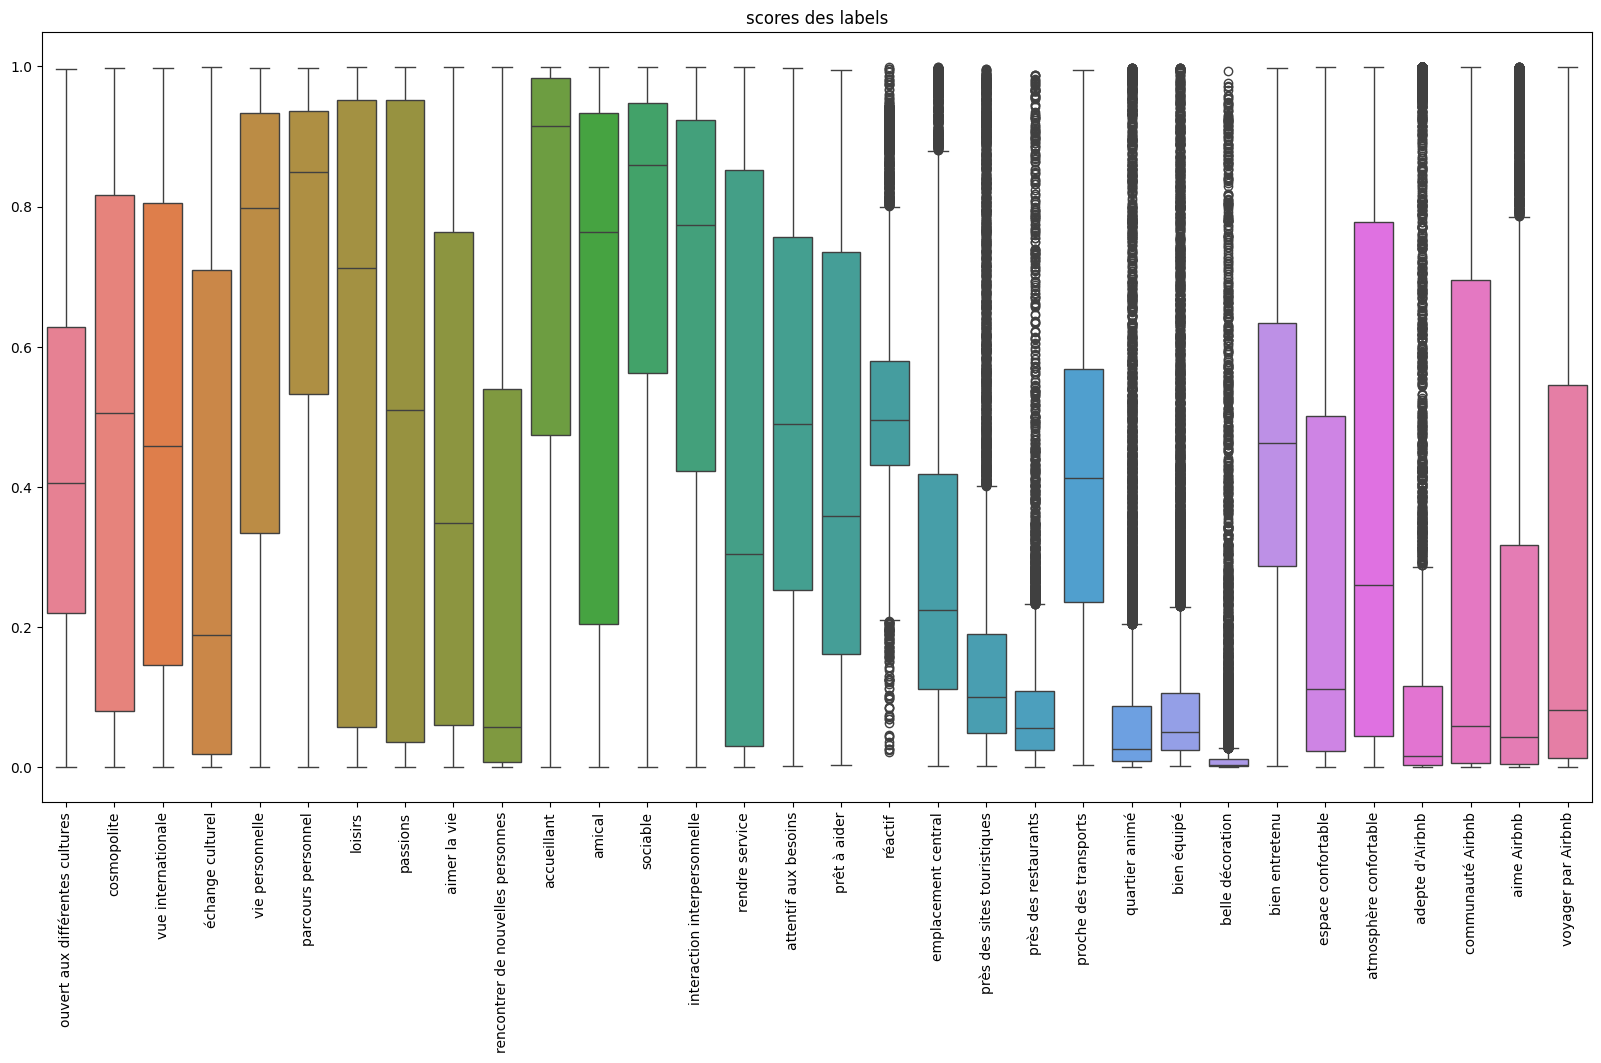

In [111]:
##查看分布：筛除分布异常的:过低或者异常值过多！
import matplotlib.pyplot as plt
import seaborn as sns 

data=res_fr_.drop(columns='sp')
print(data.columns)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.boxplot(data)
plt.title('scores des labels')

In [112]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
##KMO & BARTLETTE 检验数据是否适合因子分析

data=res_fr_.drop(columns='sp')
# KMO 检验
kmo_all, kmo_model = calculate_kmo(data)
print(f"KMO Measure: {kmo_model:.2f}")

# Bartlett 球形检验
chi_square_value, p_value = calculate_bartlett_sphericity(data)
print(f"Bartlett's test chi-square: {chi_square_value:.2f}, p-value: {p_value:.3f}")

KMO Measure: 0.86
Bartlett's test chi-square: 273072.95, p-value: 0.000


d:\miniconda3\envs\transformers_env\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,F1,F2,F3,F4,F5,F6,F7
ouvert aux différentes cultures,0.138194,0.816710,0.061252,-0.031446,0.020217,0.024727,-0.015444
cosmopolite,-0.034018,0.774513,0.025367,0.128311,0.099697,-0.031622,-0.050071
vue internationale,0.147429,0.852164,0.014567,-0.106570,-0.106169,-0.084597,-0.045580
échange culturel,-0.140454,0.576081,0.175980,0.051015,0.076786,0.012599,-0.042297
vie personnelle,0.176515,-0.084933,0.137854,0.824594,0.070582,-0.151508,-0.063289
parcours personnel,0.205162,0.031360,0.034406,0.814545,0.050596,-0.044266,-0.100650
loisirs,-0.161426,0.399321,-0.077979,0.459007,0.097022,0.093884,0.128108
passions,-0.308369,0.314021,-0.087930,0.540255,-0.030130,0.071916,0.142429
aimer la vie,-0.205422,0.170929,0.074185,0.575117,-0.019261,-0.045827,0.254020
rencontrer de nouvelles personnes,-0.088444,0.278978,0.589732,-0.094845,-0.051935,-0.149533,-0.065434


<Axes: >

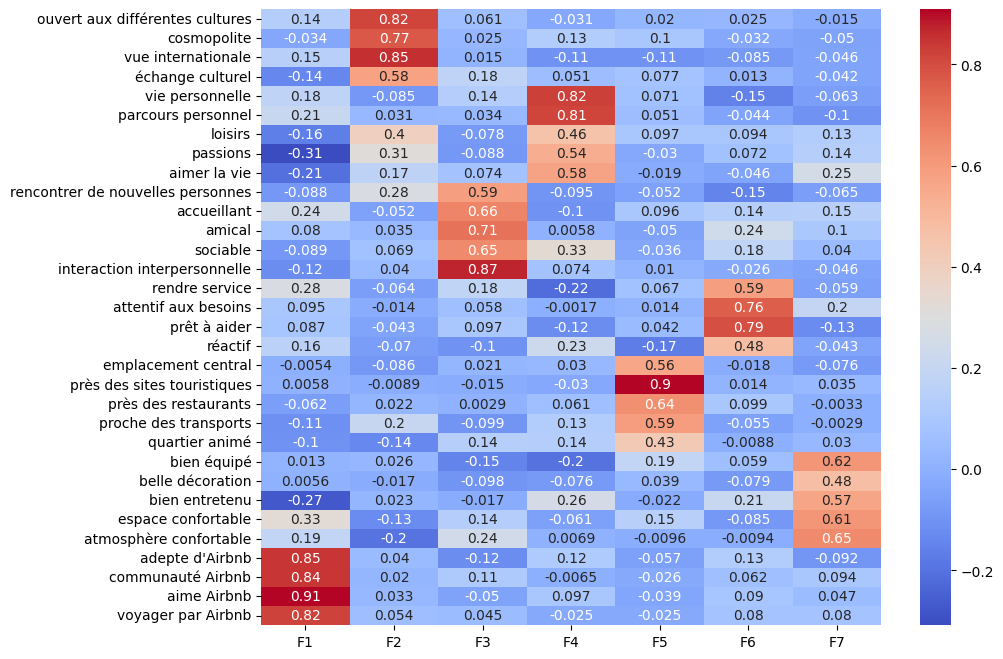

In [113]:
from factor_analyzer import FactorAnalyzer 
data_efa=res_fr_.drop(columns=['sp'])

fa = FactorAnalyzer(n_factors=7, rotation="oblimin")#permet la corrélation entre des facteurs!!
fa.fit(data_efa)


loadings=fa.loadings_
loadings_df = pd.DataFrame(loadings, index=data_efa.columns, columns=["F1", "F2","F3","F4",'F5','F6','F7'])
display(loadings_df)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
# loadings_df.to_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/3factor_loading_6_fr_oblimin32.csv', index=True)


# REXAMINER!

# 合并ENFR:

In [17]:
import pandas as pd

res_en=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_en5.csv',sep=',', on_bad_lines='skip', encoding='utf-8')
res_fr=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_fr5.csv',sep=',', on_bad_lines='skip', encoding='utf-8')
print('EN:',len(res_en.columns))
print(res_en.columns)

print('FR:',len(res_fr.columns))
print(res_fr.columns)


EN: 33
Index(['sp', 'open to different cultures', 'cosmopolitan',
       'international view', 'cultural exchange', 'personal life',
       'life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'thoughtful service', 'attentive to needs',
       'willing to help', 'responsive', 'central location',
       'close to attraction', 'close to restaurants',
       'close to transport connections', 'lively neighborhood',
       'well-equipped', 'well-decorated', 'well-maintained', 'cosy place',
       'comfortable atmosphere', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb'],
      dtype='object')
FR: 33
Index(['sp', 'ouvert aux différentes cultures', 'cosmopolite',
       'vue internationale', 'échange culturel', 'vie personnelle',
       'parcours personnel', 'loisirs', 'passions', 'aimer la vie',
       'rencontrer de nouvelles personnes', 'accueillant

In [18]:
#把fr的列名字换成en
fr2en=dict(zip(res_fr.columns, res_en.columns))
print(fr2en)
print(len(fr2en))
res_fr.rename(columns=fr2en, inplace=True)
#print(res_fr.columns)

#合并fr，en结果：
print(len(res_en), len(res_fr))
res=pd.concat([res_en, res_fr], axis=0)
print(len(res))

{'sp': 'sp', 'ouvert aux différentes cultures': 'open to different cultures', 'cosmopolite': 'cosmopolitan', 'vue internationale': 'international view', 'échange culturel': 'cultural exchange', 'vie personnelle': 'personal life', 'parcours personnel': 'life experiences', 'loisirs': 'divers interests', 'passions': 'hobbies', 'aimer la vie': 'enjoy life', 'rencontrer de nouvelles personnes': 'meet new people', 'accueillant': 'welcoming', 'amical': 'friendly', 'sociable': 'sociable', 'interaction interpersonnelle': 'interpersonal interaction', 'rendre service': 'thoughtful service', 'attentif aux besoins': 'attentive to needs', 'prêt à aider': 'willing to help', 'réactif': 'responsive', 'emplacement central': 'central location', 'près des sites touristiques': 'close to attraction', 'près des restaurants': 'close to restaurants', 'proche des transports': 'close to transport connections', 'quartier animé': 'lively neighborhood', 'bien équipé': 'well-equipped', 'belle décoration': 'well-deco

In [ ]:
res=res[['sp','open to different cultures', 'cosmopolitan','international view', 'cultural exchange', 
         'personal life','life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable','interpersonal interaction', 
       'thoughtful service', 'attentive to needs', 'willing to help', 'responsive',
       'fan of Airbnb', 'Airbnb community','love Airbnb', 'travel with Airbnb']]
print(res.columns)
print(len(res.columns))
##STOKCE!!!6没有loca和equipment
res.to_csv('D:/Master_ENC/mini_memoire/res_tactiques2/res_zsc6.csv',index=False)


Index(['sp', 'open to different cultures', 'cosmopolitan',
       'international view', 'cultural exchange', 'personal life',
       'life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'thoughtful service', 'attentive to needs',
       'willing to help', 'responsive', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb'],
      dtype='object')
23


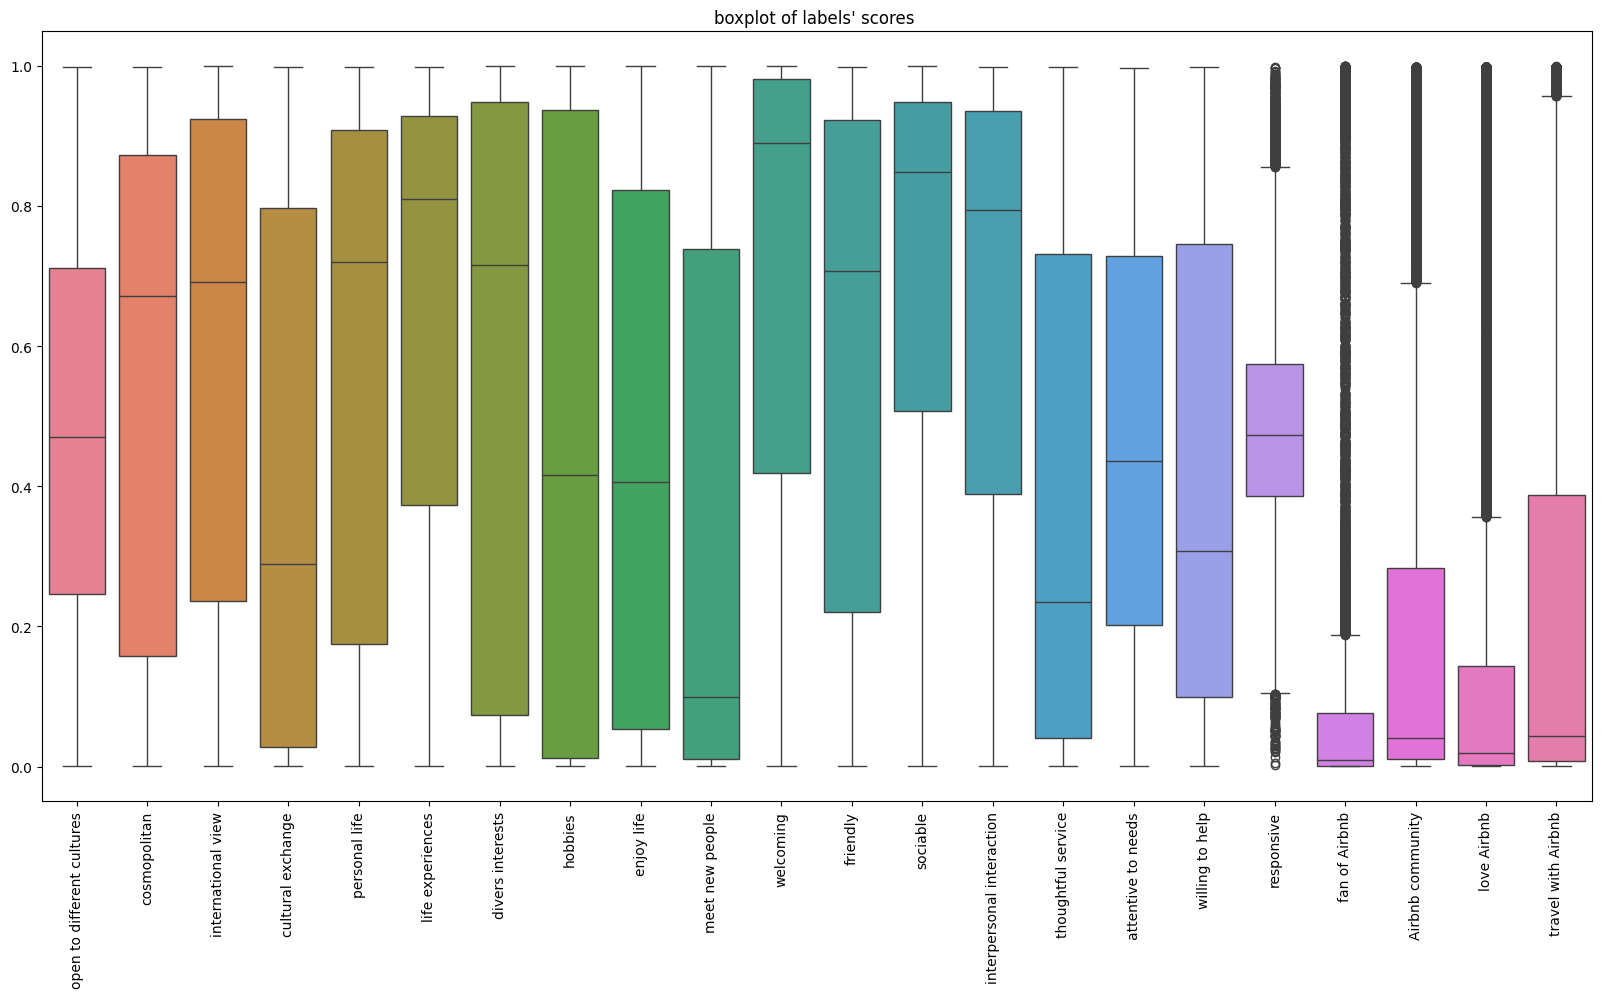

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
data=res.drop(columns='sp')
plt.figure(figsize=(20,10))
sns.boxplot(data)
plt.title("boxplot of labels' scores ")
plt.xticks(rotation=90)
plt.savefig('D:/Master_ENC/mini_memoire/res_tactiques2/boxplot_labels6.jpg', dpi=300)

22
20882


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1,2,3,4
open to different cultures,0.081748,0.077422,0.014071,0.819068,0.043191
cosmopolitan,-0.073642,-0.011161,0.194309,0.748612,-0.009596
international view,0.070972,-0.027075,-0.075434,0.891007,-0.033560
cultural exchange,-0.124390,0.167956,0.108169,0.538914,-0.025195
personal life,0.163688,0.137042,0.755271,-0.139447,-0.086159
life experiences,0.184129,-0.006864,0.731533,0.007955,-0.026137
divers interests,-0.122875,-0.099291,0.638133,0.299833,0.141798
hobbies,-0.150708,-0.036349,0.706534,0.131502,-0.011420
enjoy life,-0.099508,0.120341,0.677272,0.071370,-0.061254
meet new people,-0.051455,0.649357,-0.136335,0.301081,-0.205701


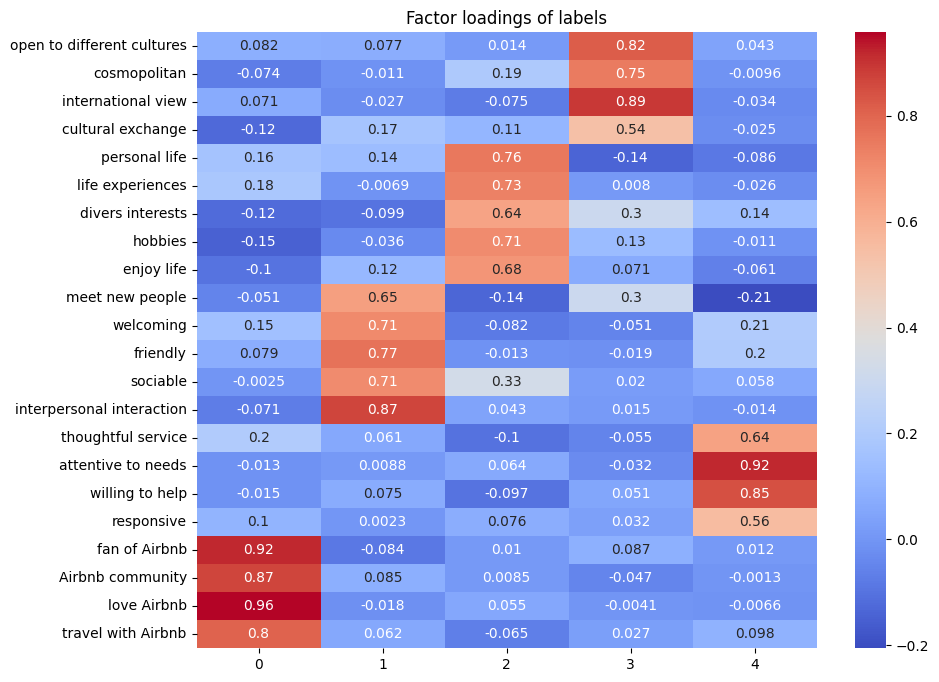

In [22]:
from factor_analyzer import FactorAnalyzer 
#data=res.drop(columns=['sp','well-maintained'])

data=res[['open to different cultures', 'cosmopolitan','international view', 'cultural exchange', 
          'personal life','life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable','interpersonal interaction', 
       'thoughtful service', 'attentive to needs', 'willing to help', 'responsive', 
      #  'central location','close to attraction', 'close to restaurants', 'close to transport connections', 'lively neighborhood',
      #  'well-equipped', 'well-decorated', 'cosy place', 'comfortable atmosphere',# 'well-maintained'
       'fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb'
       ]]
print(len(data.columns))
print(len(data))



fa = FactorAnalyzer(n_factors=5, rotation="oblimin")#permet la corrélation entre des facteurs!!
fa.fit(data)

loadings=fa.loadings_
loadings_df = pd.DataFrame(loadings, index=data.columns)#, columns=["F1", "F2","F3","F4",'F5']
display(loadings_df)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('Factor loadings of labels')

loadings_df.to_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/6factor_loading_oblimin22.csv', index=True)


In [ ]:
##V3存档：
# res_zsc3=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_zsc3.csv')
# print(res_zsc3.columns)
# print(len(res_zsc3.columns))

Index(['sp', 'open to different cultures', 'love traveling', 'cosmopolitan',
       'international view', 'cultural exchange', 'embrace new experiences',
       'meet new people', 'hospitable', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'experienced host', 'thoughtful service',
       'attentive to needs', 'give advices', 'willing to help',
       'central location', 'close to attraction', 'close to restaurants',
       'close to transport connections', 'lively neighborhood',
       'well-equipped', 'well-decorated', 'well-maintained', 'cosy place',
       'comfortable atmosphere', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb'],
      dtype='object')
32


In [ ]:
##V4：删去well-maintained存档
# res_=res.drop(columns='well-maintained')
# print(res_.columns)
# res_.to_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_zsc4.csv', index=False)

Index(['sp', 'open to different cultures', 'love traveling', 'cosmopolitan',
       'international view', 'cultural exchange', 'embrace new experiences',
       'meet new people', 'hospitable', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'experienced host', 'thoughtful service',
       'attentive to needs', 'give advices', 'willing to help',
       'central location', 'close to attraction', 'close to restaurants',
       'close to transport connections', 'lively neighborhood',
       'well-equipped', 'well-decorated', 'cosy place',
       'comfortable atmosphere', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb'],
      dtype='object')


## FIG2 :correlation circle:

Explained variance ratio:0.5689795037908838


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


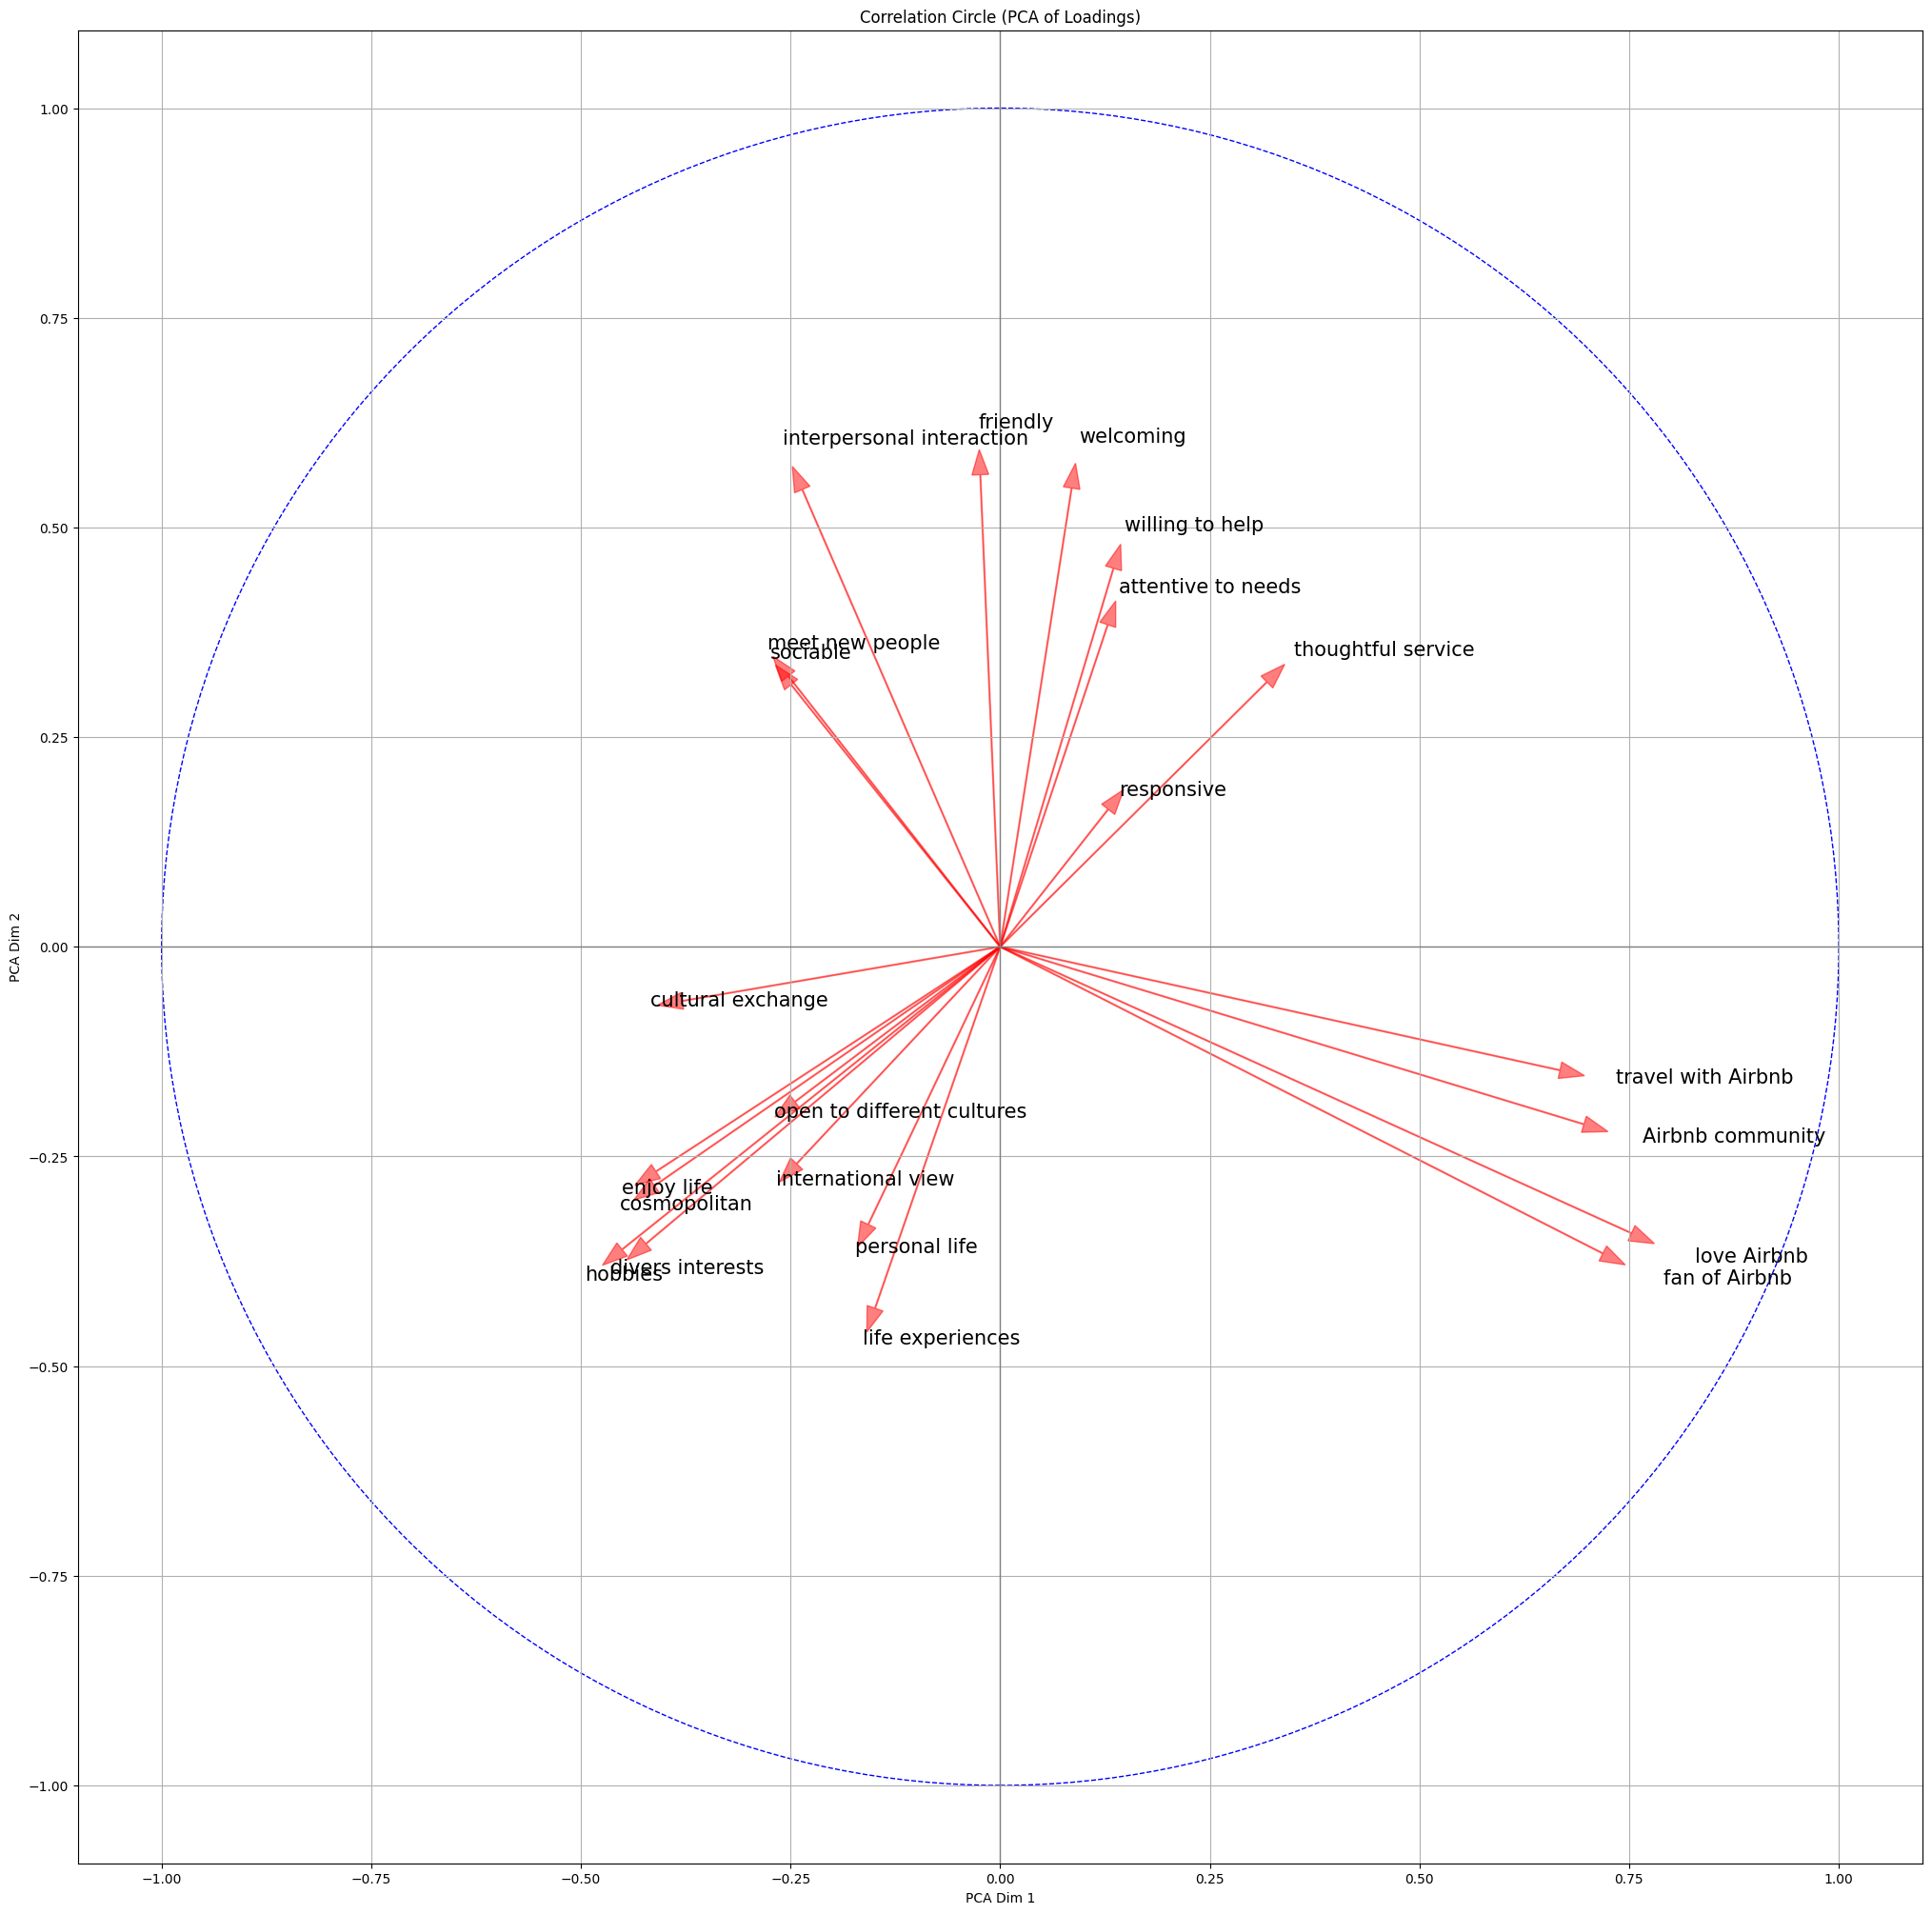

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca=PCA(n_components=2)
loadings_2d=pca.fit_transform(loadings)
print(f"Explained variance ratio:{pca.explained_variance_ratio_.sum()}")

plt.figure(figsize=(25, 25))
# 画单位圆
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# 坐标轴
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# PCA画箭头
for i, var in enumerate(data.columns):
    plt.arrow(0, 0, loadings_2d[i, 0], loadings_2d[i, 1], 
              color='red', alpha=0.5, head_width=0.02)
    plt.text(loadings_2d[i, 0]*1.1, loadings_2d[i, 1]*1.1, var, fontsize=15)


plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Correlation Circle (PCA of Loadings)')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='datalim')
plt.savefig('D:/Master_ENC/mini_memoire/res_tactiques2/6labels_loadings_cc2D.jpg', dpi=300)
plt.show()



## GIF2.2 : 3D

Explained variance ratios (3D): 0.7827277280685783


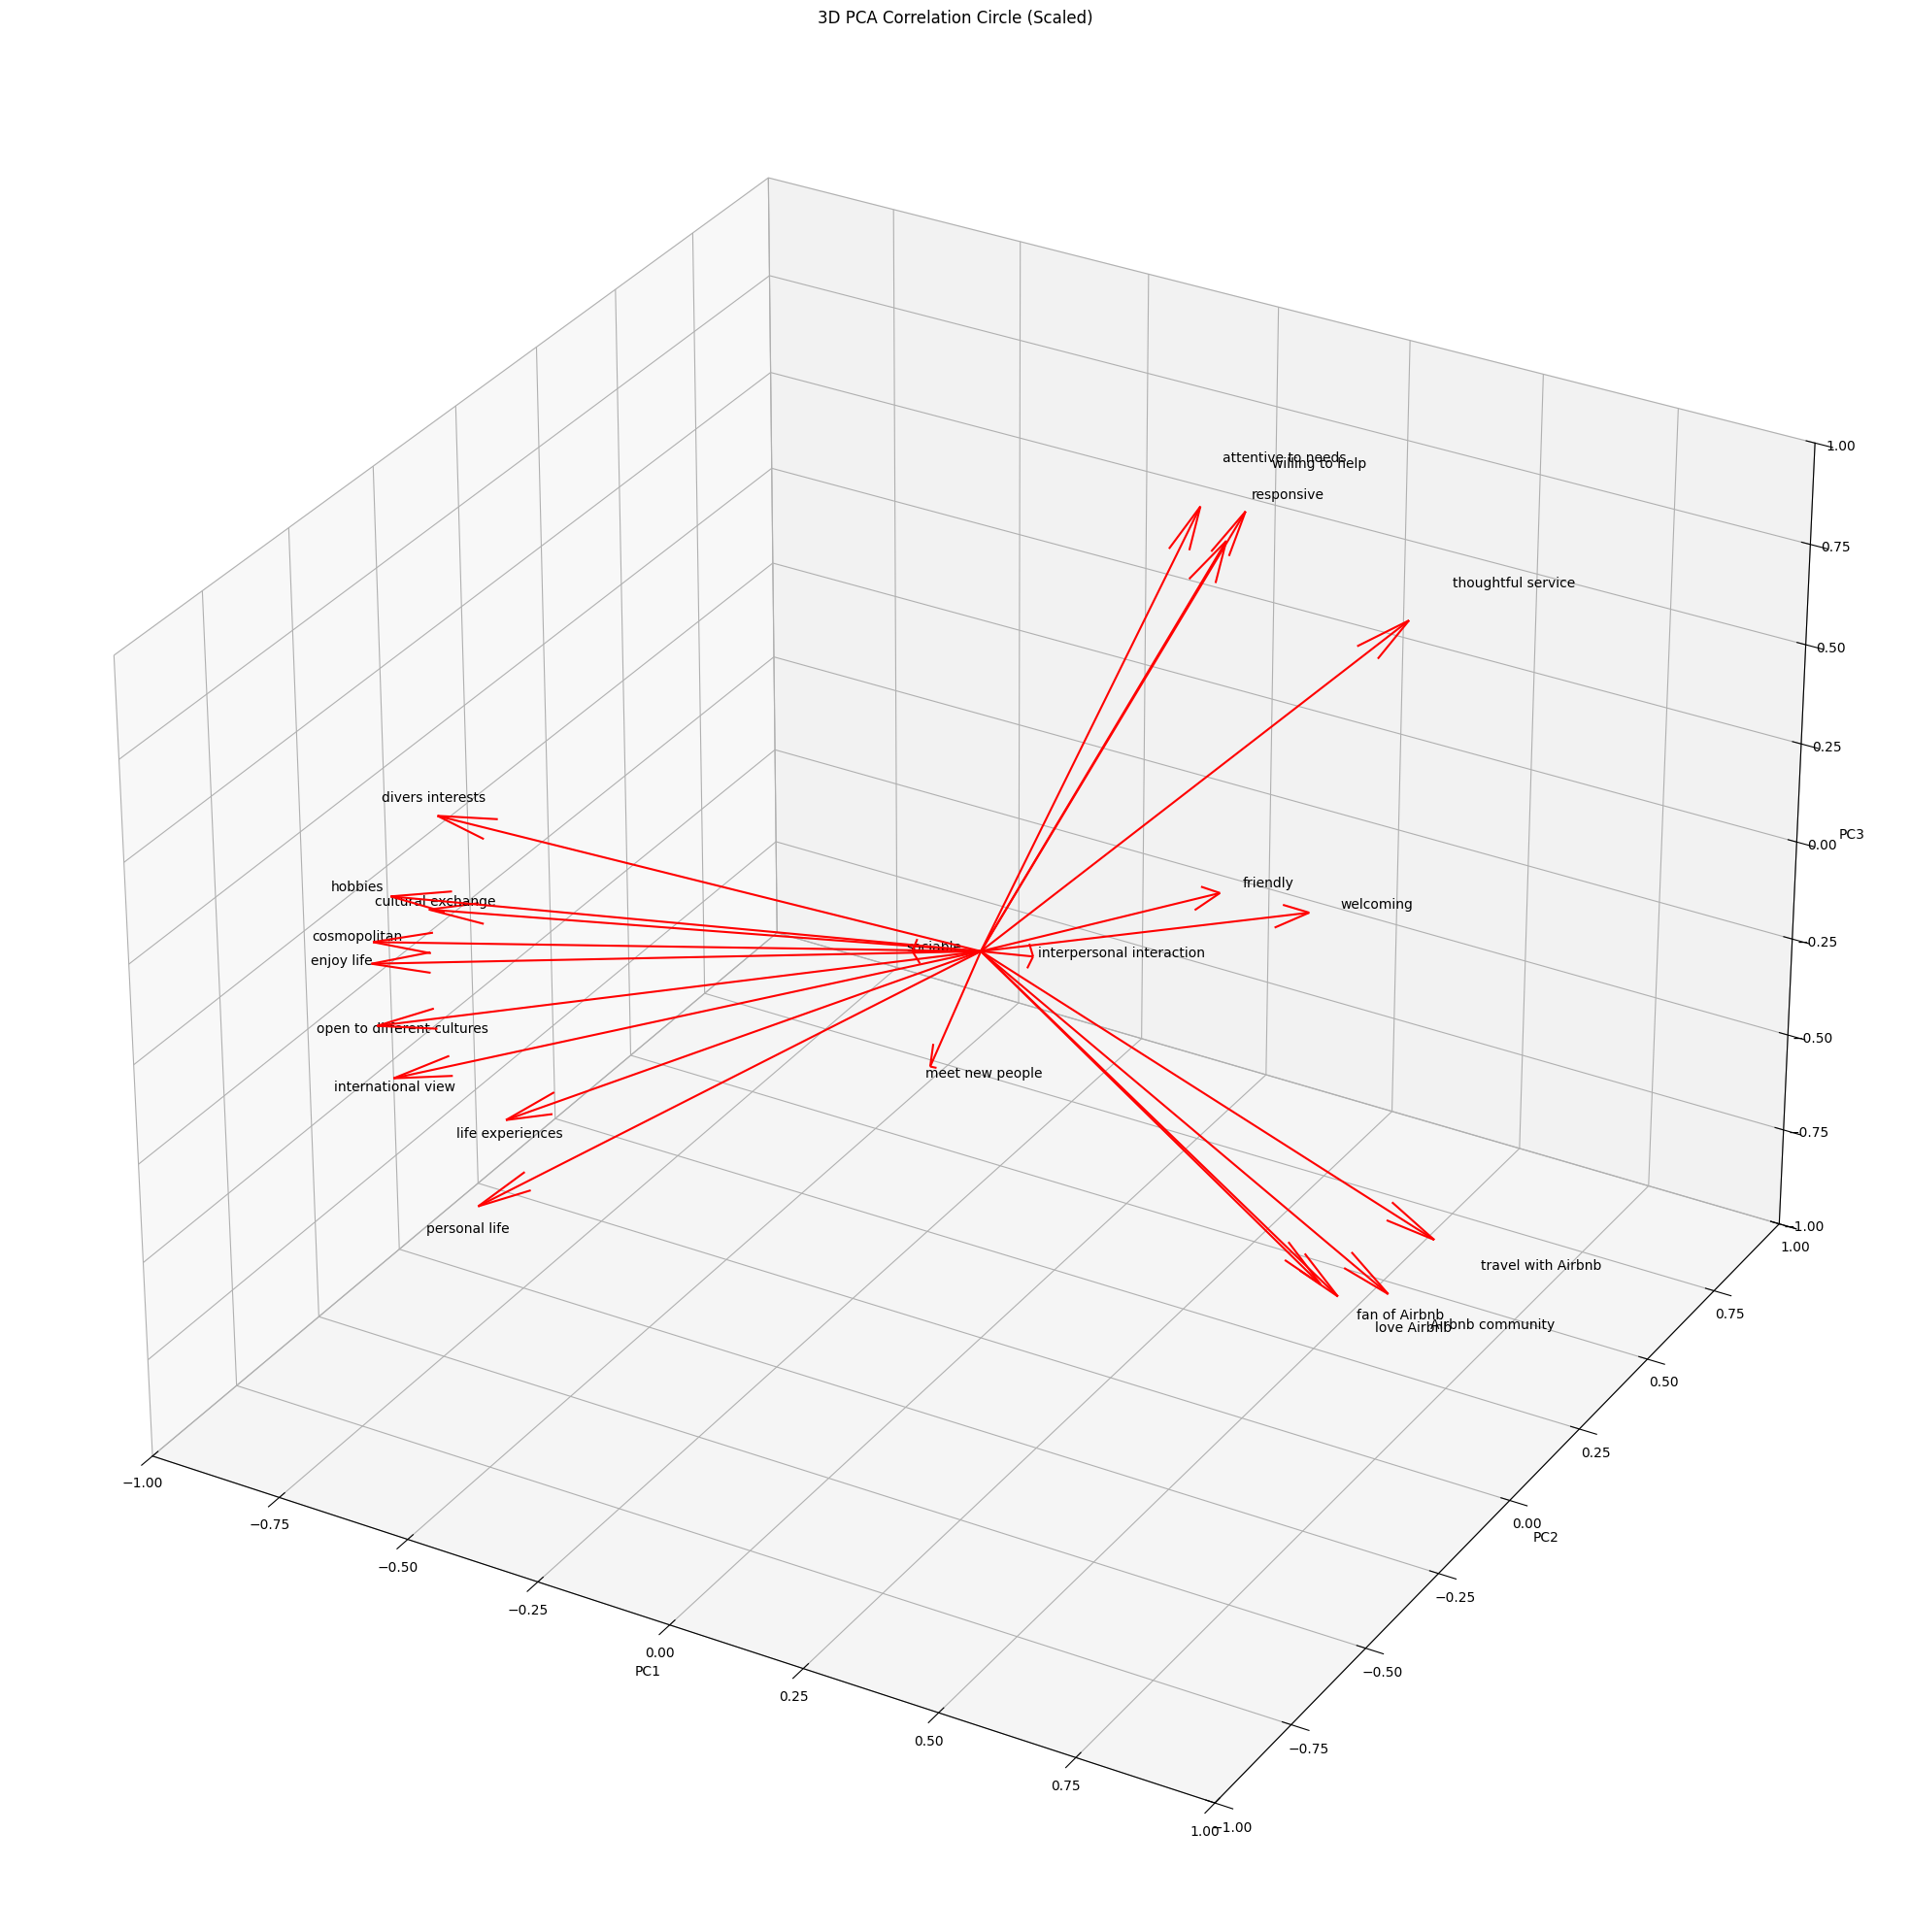

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_3d=PCA(n_components=3)
loadings_3d=pca_3d.fit_transform(loadings)



fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')


# 缩放向量
norms = np.linalg.norm(loadings_3d, axis=1)
loadings_3d_scaled = loadings_3d / norms[:, np.newaxis] #0.8
print("Explained variance ratios (3D):", pca_3d.explained_variance_ratio_.sum())


# 画箭头
for i, var in enumerate(data.columns):
    ax.quiver(0, 0, 0,
              loadings_3d_scaled[i, 0], 
              loadings_3d_scaled[i, 1], 
              loadings_3d_scaled[i, 2], 
              color='red', arrow_length_ratio=0.1)
    
    ax.text(loadings_3d_scaled[i, 0]*1.1, 
            loadings_3d_scaled[i, 1]*1.1, 
            loadings_3d_scaled[i, 2]*1.1, 
            var, fontsize=10)

# 坐标轴限制
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('3D PCA Correlation Circle (Scaled)')
plt.tight_layout()
#plt.savefig(f'D:/Master_ENC/mini_memoire/res_tactiques2/5factor_loading7_enfr_oblimin31_cc3D.jpg', dpi=300)
plt.show()

## FIG3: 箱线图

boxplot（传统箱线图）

    主要用于小规模数据集，显示数据的中位数、四分位数、异常值。

    适用于数据分布较均匀的情况。

    缺点：当数据量大、存在长尾分布时，细节容易丢失。
特点：

    箱子（IQR）：表示数据中间 50% 的范围（Q1 到 Q3）。

    须（Whiskers）：表示数据的正常范围（1.5 × IQR）。

    点（Outliers）：超出 1.5 × IQR 的异常值。


## 寻找特定代表性文本：


In [175]:
top=res.sort_values(by='attentive to needs',ascending=False).head(10)
for i,text in enumerate(top.sp):
    print(f'\n {i} text:\n {text}')



 0 text:
 Je suis originaire de Paris , j'ai l'habitude de louer des appartements et des villas pour les  vacances via airbnb.

Je suis également propriétaire d’ appartement , que je loue au mois .
Je suis donc très attentif au besoin de mes locataires

 1 text:
 We have spent a lot of time traveling for work and leisure. We understand what people need when they're away from home. Guillaume and his partners manage arrivals and checkins, adding a friendly touch to every visitor. We all genuinely love Paris and try to make it easy for people to come and visit the city.

 2 text:
 From Paris and New York. Actor Producer Director, FilmFestival organizer. I am always happy to meet new people and attend to their needs regarding their stay in my place in Paris. When I am a guest myself, I am very considerate, and attentive. I like to read, I am by nature curious about life around us, though not nosy of people's business, and I am pleasant by nature. Rarely, unpleasant people and situations g

## 计算加权平均！moyen pondérée :

In [25]:
import pandas as pd
res=pd.read_csv('D:/Master_ENC/mini_memoire/res_tactiques2/result_zsc6.csv', sep=',', on_bad_lines='skip', encoding='utf-8')
print(len(res.columns))
print(len(res))
print(res.columns)

23
20882
Index(['sp', 'open to different cultures', 'cosmopolitan',
       'international view', 'cultural exchange', 'personal life',
       'life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'thoughtful service', 'attentive to needs',
       'willing to help', 'responsive', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb'],
      dtype='object')


22


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

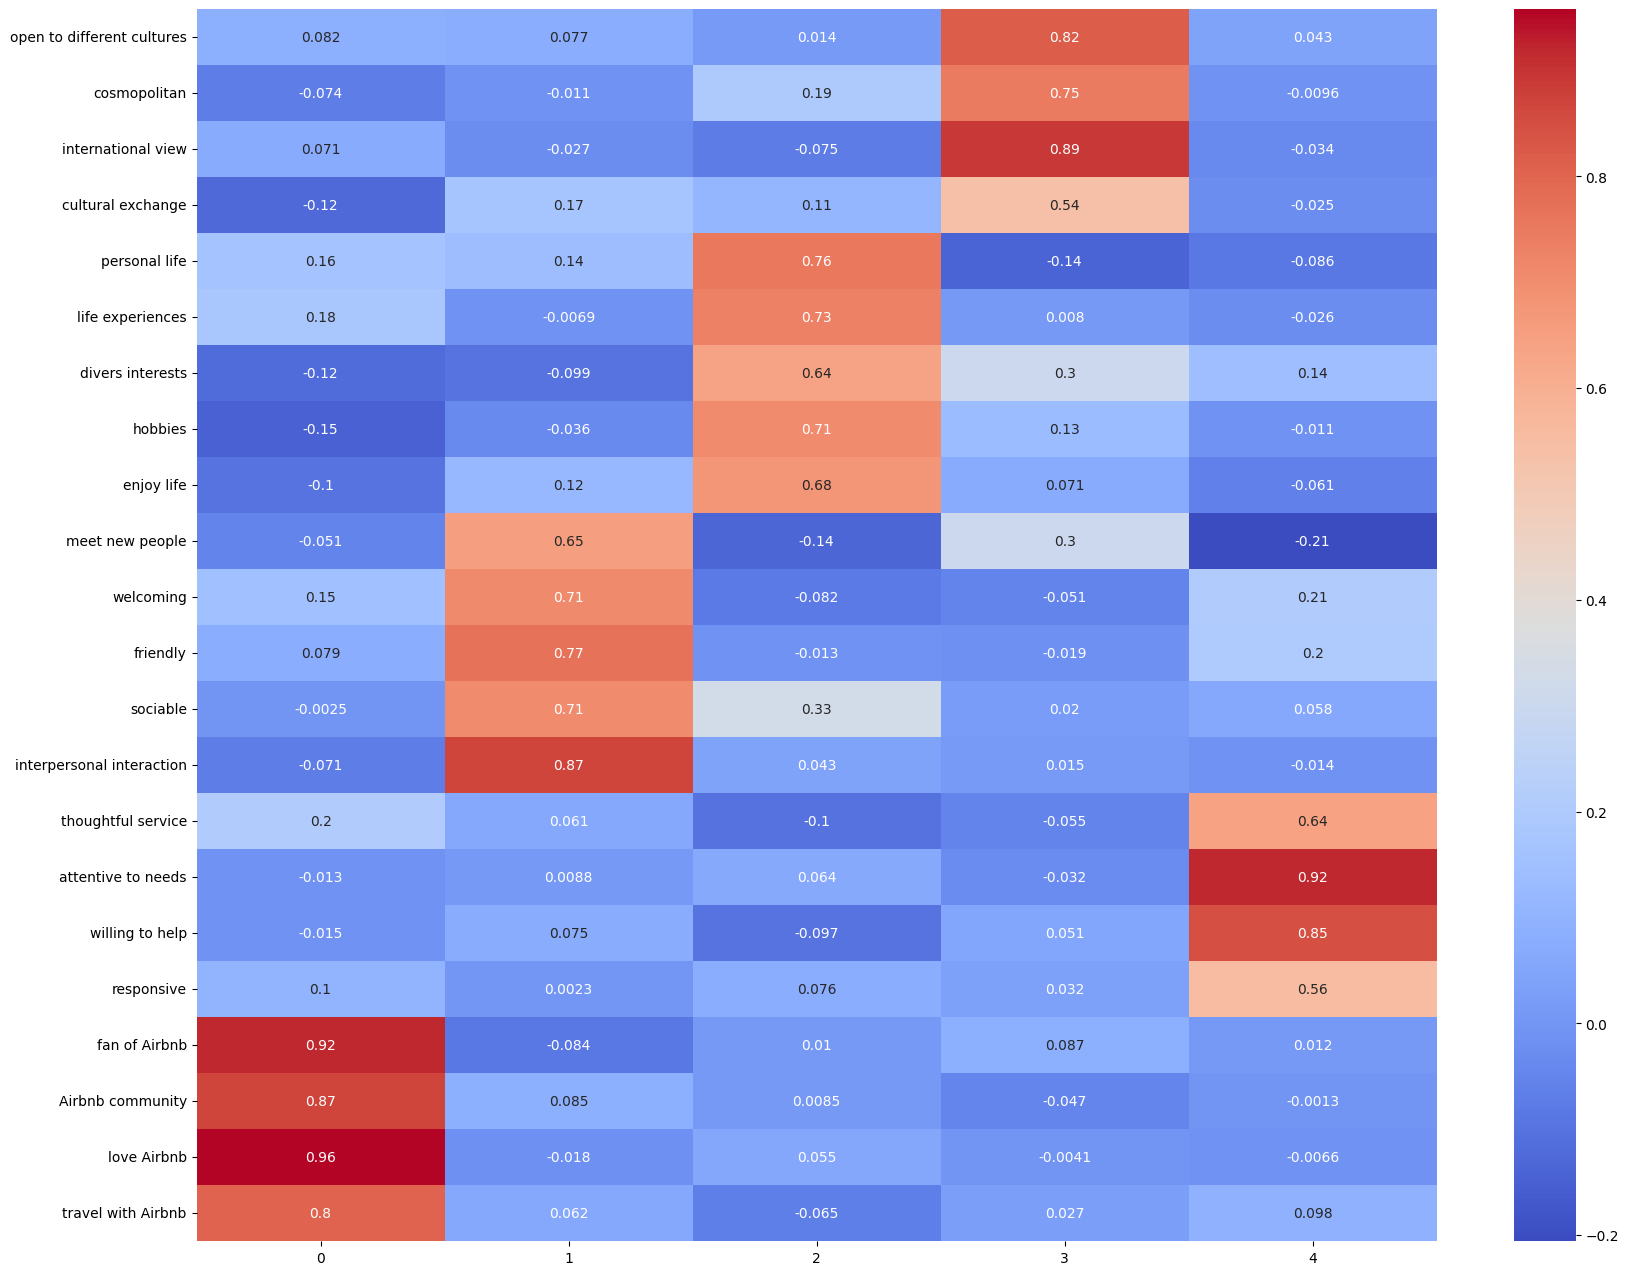

In [26]:
##loadings_df:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# data=res.drop(columns='sp')

data=res[['open to different cultures', 'cosmopolitan','international view', 'cultural exchange', 
          'personal life','life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable','interpersonal interaction', 
       'thoughtful service', 'attentive to needs', 'willing to help', 'responsive', 
      #  'central location','close to attraction', 'close to restaurants', 'close to transport connections', 'lively neighborhood',
      #  'well-equipped', 'well-decorated',  'cosy place', 'comfortable atmosphere', #'well-maintained',
       'fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb'
       ]]
print(len(data.columns))

n_tactics=5
fa=FactorAnalyzer(n_factors=n_tactics, rotation='oblimin')
fa.fit(data)
loadings=fa.loadings_
loadings_df=pd.DataFrame(loadings, index=data.columns)
# display(loadings_df)


plt.figure(figsize=(20,16))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')

In [27]:
#找到标签对应的策略:
loadings_df.rename(columns={
                         0:"exemplification",
                         1:"ingratiation_host",
                         2:"ingratiation_honest",
                         3:"ingratiation_open",
                         4:"enhancement_host",
                        #  5:'enhancement_location',
                        #  6:'enhancement_equipment'
                         }, inplace=True)
display(loadings_df)
print(loadings_df.columns)

,exemplification,ingratiation_host,ingratiation_honest,ingratiation_open,enhancement_host
open to different cultures,0.081748,0.077422,0.014071,0.819068,0.043191
cosmopolitan,-0.073642,-0.011161,0.194309,0.748612,-0.009596
international view,0.070972,-0.027075,-0.075434,0.891007,-0.033560
cultural exchange,-0.124390,0.167956,0.108169,0.538914,-0.025195
personal life,0.163688,0.137042,0.755271,-0.139447,-0.086159
life experiences,0.184129,-0.006864,0.731533,0.007955,-0.026137
divers interests,-0.122875,-0.099291,0.638133,0.299833,0.141798
hobbies,-0.150708,-0.036349,0.706534,0.131502,-0.011420
enjoy life,-0.099508,0.120341,0.677272,0.071370,-0.061254
meet new people,-0.051455,0.649357,-0.136335,0.301081,-0.205701


Index(['exemplification', 'ingratiation_host', 'ingratiation_honest',
       'ingratiation_open', 'enhancement_host'],
      dtype='object')


In [28]:
# labels2tac={
#     "ingratiation_open":['open to different cultures', 'cosmopolitan', 'international view','cultural exchange','embrace new experiences'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2, idem 'proactive'
#     'ingratiation_host':['meet new people', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],
#     "ingratiation_personal":['personal info', 'personal life', 'life experiences','hobbies', 'enjoy life'],
#     'enhancement_host':['experienced host','thoughtful service', 'attentive to needs','give advices','willing to help'],#'ensuring a good stay', 'love the city', 'knowledge of the city'
#     'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
#     'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
#     'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']
# }  

# labels2tac={
#     "ingratiation_open":['open to different cultures','love traveling', 'cosmopolitan', 'international view','cultural exchange','embrace new experiences'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2，proactive出现交叉载荷！
#     'ingratiation_host':['meet new people', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],
#     'enhancement_host':['experienced host','thoughtful service', 'attentive to needs','give advices','willing to help'],#删去'ensuring a good stay', 'love the city', 'knowledge of the city'
#     'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
#     'enhancement_equipment':['well-equipped', 'well-decorated',"well-maintained",'cosy place', 'comfortable atmosphere'],
#     'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
# }    

# labels2tac={
#     "ingratiation_open":['open to different cultures', 'cosmopolitan','international view','cultural exchange','embrace new experiences'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2，proactive出现交叉载荷！
#     'ingratiation_host':['meet new people', 'hospitable', 'welcoming', 'friendly','sociable', 'interpersonal interaction'],
#     'enhancement_host':['experienced host','thoughtful service', 'attentive to needs','give advices','willing to help'],
#     'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
#     'enhancement_equipment':['well-equipped', 'well-decorated','cosy place', 'comfortable atmosphere'],#'well-maintained'
#     'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
# }    


labels2tac={
    "ingratiation_open":['open to different cultures','cosmopolitan','international view','cultural exchange'],#'love sharing','responsive and supportive'cross loading严重！差距远小于0,2，proactive出现交叉载荷！
    "ingratiation_honest":['personal life','life experiences','divers interests','hobbies','enjoy life'], #'love traveling'和interest一致，#,'family status','personal info','family'
    'ingratiation_host':['meet new people', 'welcoming', 'friendly','sociable', 'interpersonal interaction',],#'hospitable'有点交叉载荷，先去除
    'enhancement_host':['thoughtful service', 'attentive to needs','willing to help','responsive'],#'give advices','experienced host','love sharing'
    # 'enhancement_location':['central location', 'close to attraction','close to restaurants','close to transport connections','lively neighborhood'],
    # 'enhancement_equipment':['well-equipped', 'well-decorated','cosy place', 'comfortable atmosphere'],#"well-maintained",
    'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
}    

labels_list=[label for labels in labels2tac.values() for label in labels]
print(len(labels_list))
print(labels_list)


label2loading={}
for tactic, labels in labels2tac.items() :
    for label in labels :
        idx_label=list(labels_list).index(label)
        # print(tactic, label,idx_label)
        loading=loadings_df.at[label,tactic]
        if label not in label2loading:
            label2loading[label]=loading
       
print(label2loading)

22
['open to different cultures', 'cosmopolitan', 'international view', 'cultural exchange', 'personal life', 'life experiences', 'divers interests', 'hobbies', 'enjoy life', 'meet new people', 'welcoming', 'friendly', 'sociable', 'interpersonal interaction', 'thoughtful service', 'attentive to needs', 'willing to help', 'responsive', 'fan of Airbnb', 'Airbnb community', 'love Airbnb', 'travel with Airbnb']
{'open to different cultures': np.float64(0.8190684443557118), 'cosmopolitan': np.float64(0.7486116552359389), 'international view': np.float64(0.8910066969617557), 'cultural exchange': np.float64(0.5389137265920142), 'personal life': np.float64(0.7552712901330028), 'life experiences': np.float64(0.7315332263668295), 'divers interests': np.float64(0.6381326758538001), 'hobbies': np.float64(0.7065340976447286), 'enjoy life': np.float64(0.6772722399040659), 'meet new people': np.float64(0.6493573259978206), 'welcoming': np.float64(0.7097225665419036), 'friendly': np.float64(0.76948657

In [29]:
def calculate_weighted_average (scores, weights):
    weighted_sum = sum([score * weight for score, weight in zip(scores, weights)])
    total_weight = sum(weights)
    weighted_average = weighted_sum / total_weight
    return weighted_average

## calculer la moy pondéré de chq tac :
tactics_dict={
    "ingratiation_open":[],
    'ingratiation_honest':[],
    "ingratiation_host":[], 
    'enhancement_host':[],
    # 'enhancement_location':[],
    # 'enhancement_equipment':[],
    'exemplification':[]
}

res_zsc=res
for i in range(len(res_zsc)):
    row=res_zsc.iloc[i,:]
    #print(type(row))

    for tactic, labels in labels2tac.items():
        
        idx=[list(labels_list).index(label) +1 for label in labels]#+1sshi因为有第一列sp！！！
        scores=[row.iloc[i] for i in idx]
        weights=[label2loading[label] for label in labels]
        weighted_average=calculate_weighted_average(scores=scores, weights=weights)
        tactics_dict[tactic].append(weighted_average)
        
        # print('tactic:',tactic)
        # print('labels:',labels)
        # print('labels index:',idx)
        # print('scores:',scores)
        # print("weights:", weights)
        # print(f'weighted_average for {tactic}:', weighted_average)


    #     break #chq tac
    # print(f'{i} row: {tactics_dict}')
    # break #chq row
print(i)

tactics_df=pd.DataFrame.from_dict(tactics_dict, orient='columns')
display(tactics_df.head())

20881


,ingratiation_open,ingratiation_honest,ingratiation_host,enhancement_host,exemplification
0,0.713374,0.418507,0.823924,0.961830,0.187085
1,0.324219,0.864965,0.474071,0.608792,0.093501
2,0.095280,0.174868,0.023545,0.141742,0.011136
3,0.218907,0.138558,0.957528,0.816942,0.256239
4,0.481458,0.687737,0.366772,0.355100,0.475037


In [ ]:
# res_zsc_tactics3=pd.read_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/result_zsc_tactics3.csv')
# print(len(res_zsc3.columns))
# print(res_zsc3.columns)

32
Index(['sp', 'open to different cultures', 'love traveling', 'cosmopolitan',
       'international view', 'cultural exchange', 'embrace new experiences',
       'meet new people', 'hospitable', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'experienced host', 'thoughtful service',
       'attentive to needs', 'give advices', 'willing to help',
       'central location', 'close to attraction', 'close to restaurants',
       'close to transport connections', 'lively neighborhood',
       'well-equipped', 'well-decorated', 'well-maintained', 'cosy place',
       'comfortable atmosphere', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb'],
      dtype='object')


In [ ]:
# ##合并labels+tacs，
res=res.reset_index()#一次性？
res_zsc_tactics=pd.concat([res, tactics_df], axis=1)
res_zsc_tactics.drop(columns='index',inplace=True)
display(res_zsc_tactics)

,sp,open to different cultures,cosmopolitan,international view,cultural exchange,personal life,life experiences,divers interests,hobbies,enjoy life,...,responsive,fan of Airbnb,Airbnb community,love Airbnb,travel with Airbnb,ingratiation_open,ingratiation_honest,ingratiation_host,enhancement_host,exemplification
0,We have spent a lot of time traveling for work...,0.326977,0.935198,0.957682,0.588577,0.010742,0.876140,0.508966,0.008257,0.721678,...,0.973056,0.285509,0.021451,0.137775,0.312313,0.713374,0.418507,0.823924,0.961830,0.187085
1,Independent photographer. \nCyclist. Often on ...,0.270624,0.088596,0.766917,0.001054,0.831021,0.953769,0.950056,0.879059,0.712023,...,0.639748,0.095682,0.017927,0.021362,0.258571,0.324219,0.864965,0.474071,0.608792,0.093501
2,"I am a writer,54, author of novels, books of l...",0.190188,0.134246,0.025538,0.012216,0.015806,0.007738,0.862305,0.063168,0.001584,...,0.380097,0.000321,0.043717,0.000308,0.001214,0.095280,0.174868,0.023545,0.141742,0.011136
3,Hello ! \r\nOur apartment is great and I am su...,0.395662,0.051395,0.305252,0.040200,0.251738,0.086520,0.174614,0.000458,0.178647,...,0.535471,0.294099,0.039286,0.050386,0.692560,0.218907,0.138558,0.957528,0.816942,0.256239
4,We are web startup entrepreneurs and bnb/garde...,0.510264,0.396760,0.800904,0.027181,0.606290,0.961894,0.943946,0.045909,0.910597,...,0.456869,0.541627,0.886296,0.281512,0.185741,0.481458,0.687737,0.366772,0.355100,0.475037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20877,"Je m'appelle Valentin, j'ai 31 ans et je suis ...",0.218138,0.438243,0.185864,0.002258,0.678590,0.890868,0.002675,0.005978,0.002138,...,0.508320,0.002889,0.002103,0.000366,0.002070,0.224702,0.333908,0.213743,0.584677,0.001830
20878,Etudiant et Voyageur quand le temps me le perm...,0.812687,0.893997,0.882580,0.780455,0.884832,0.917608,0.979098,0.917304,0.646875,...,0.478874,0.348438,0.153047,0.169618,0.714592,0.847973,0.869417,0.711750,0.588822,0.335320
20879,Bonjour ! \n\nJe m’appelle Leopold et suis un ...,0.251653,0.010971,0.272211,0.002617,0.680909,0.857141,0.023591,0.100372,0.056694,...,0.923609,0.998818,0.942046,0.996643,0.937968,0.152884,0.360718,0.675465,0.934164,0.970552
20880,Bonjour ! \nJe m’appelle Danielle et suis un g...,0.253848,0.015657,0.265442,0.003060,0.734330,0.827404,0.021238,0.097144,0.061846,...,0.926695,0.998913,0.952388,0.996552,0.922197,0.152722,0.365933,0.681398,0.934152,0.969508


In [238]:
res_zsc_tactics.to_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/result_zsc_tactics6.csv', index=False)

20882


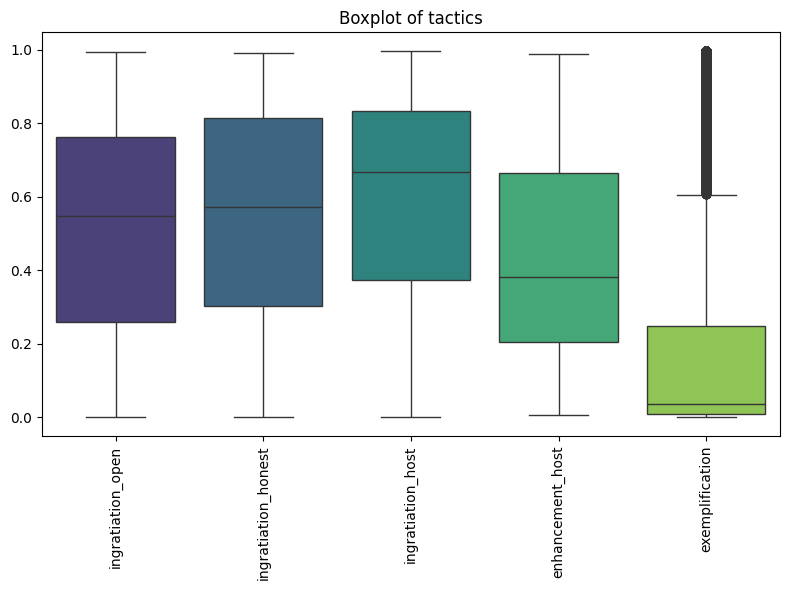

In [32]:
print(len(tactics_df))
plt.figure(figsize=(8,6))
plt.xticks(rotation=90)
sns.boxplot(tactics_df,palette='viridis')
plt.title('Boxplot of tactics')
plt.tight_layout()
plt.savefig('D:/Master_ENC/mini_memoire/res_tactiques2/6factor_loading_enfr_obliminéé_tactics_boxplot.jpg', dpi=300)


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1
ingratiation_open,-0.093650,0.711658
ingratiation_honest,-0.077689,0.586052
ingratiation_host,0.470286,0.474844
enhancement_host,0.979058,-0.042131
exemplification,0.557254,-0.047175


<Axes: >

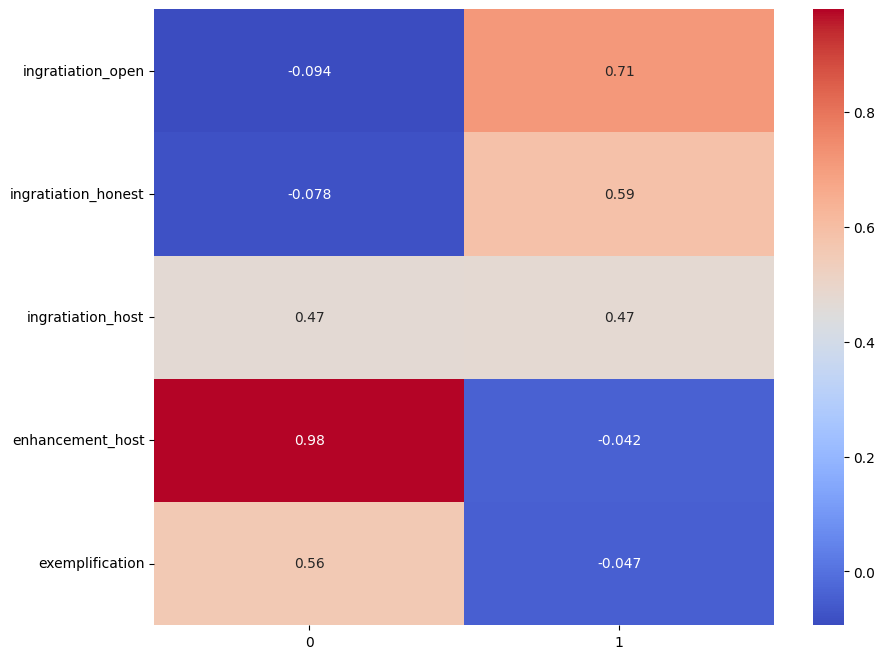

In [33]:
from factor_analyzer import FactorAnalyzer
fa=FactorAnalyzer(n_factors=2, rotation='oblimin')
fa.fit(tactics_df)

loadings_tac=fa.loadings_
loadings_tac_df=pd.DataFrame(loadings_tac, index=tactics_df.columns)#, columns=['F1','F2','F3','F4']
display(loadings_tac_df)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(loadings_tac_df, annot=True, cmap='coolwarm')

## 贴回:

In [241]:
listings=pd.read_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/listings_zsc_tactics2.csv', sep=',', on_bad_lines='skip', encoding='utf-8')

In [242]:
cols=listings.columns[-31:-1]
print(cols)

listings=listings.drop(columns=cols)
print(len(listings.columns))
print('LISTINGS:',listings.columns)


Index(['meet new people', 'open to different cultures', 'hospitable',
       'welcoming', 'interaction', 'service', 'experienced in hosting',
       'attentive to needs', 'central location', 'close to attraction',
       'well-equipped', 'cosy place', 'well-decorated', 'superhost',
       'fan of Airbnb', 'Airbnb community', 'ingratiation_open',
       'ingratiation_host', 'enhancement_host', 'enhancement_location',
       'enhancement_equipment', 'exemplification', 'tactics_count',
       'ingratiation_open_t', 'ingratiation_host_t', 'enhancement_host_t',
       'enhancement_location_t', 'enhancement_equipment_t',
       'exemplification_t', 'cluster'],
      dtype='object')
103
LISTINGS: Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       ...
       'P3', 'i_rel', 'we_rel', 'P1_rel', 'P2_rel', 'P3_rel', 'langue_',
       'price_', 'booking_rate_l30d', 'property_type_'],
      dtype=

In [243]:
##字数：
listings["len_squared"] = listings["len"] ** 2


#整理地点：
listings['host_location_paris']=listings['host_location'].apply(lambda x: 'paris' if 'paris' in str(x).lower() else 'elsewhere')
print(listings.host_location_paris.value_counts())


##整理语言：
listings['langue_fr']=listings['langue_'].apply(lambda x:'fr' if x=='fr' else('en_others') if pd.notna(x) else np.nan)
print(listings.langue_fr.value_counts())

print(listings.columns)


host_location_paris
paris        51768
elsewhere    22561
Name: count, dtype: int64
langue_fr
en_others    56040
fr           18289
Name: count, dtype: int64
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       ...
       'P1_rel', 'P2_rel', 'P3_rel', 'langue_', 'price_', 'booking_rate_l30d',
       'property_type_', 'len_squared', 'host_location_paris', 'langue_fr'],
      dtype='object', length=106)


In [244]:
res_zsc_tactics=pd.read_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/result_zsc_tactics6.csv')
print('ZSC+TACTICS:',res_zsc_tactics.columns)

listings_tactics=listings.merge(res_zsc_tactics, left_on='host_about', right_on='sp', how='left')
listings_tactics.drop(columns='sp', inplace=True)
print('LISTINGS TACTICS:',listings_tactics.columns)

ZSC+TACTICS: Index(['sp', 'open to different cultures', 'cosmopolitan',
       'international view', 'cultural exchange', 'personal life',
       'life experiences', 'divers interests', 'hobbies', 'enjoy life',
       'meet new people', 'welcoming', 'friendly', 'sociable',
       'interpersonal interaction', 'thoughtful service', 'attentive to needs',
       'willing to help', 'responsive', 'fan of Airbnb', 'Airbnb community',
       'love Airbnb', 'travel with Airbnb', 'ingratiation_open',
       'ingratiation_honest', 'ingratiation_host', 'enhancement_host',
       'exemplification'],
      dtype='object')
LISTINGS TACTICS: Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       ...
       'responsive', 'fan of Airbnb', 'Airbnb community', 'love Airbnb',
       'travel with Airbnb', 'ingratiation_open', 'ingratiation_honest',
       'ingratiation_host', 'enhancement_host', 'exemplificat

In [245]:
listings_tactics.to_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/listings_zsc_tactics6.csv', index=False)

## 返回检查factor loadings：

In [34]:
listings=pd.read_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/listings_zsc_tactics6.csv')
print(listings.columns[-45:])

Index(['i', 'we', 'P1_obj', 'P1', 'P2', 'P3', 'i_rel', 'we_rel', 'P1_rel',
       'P2_rel', 'P3_rel', 'langue_', 'price_', 'booking_rate_l30d',
       'property_type_', 'len_squared', 'host_location_paris', 'langue_fr',
       'open to different cultures', 'cosmopolitan', 'international view',
       'cultural exchange', 'personal life', 'life experiences',
       'divers interests', 'hobbies', 'enjoy life', 'meet new people',
       'welcoming', 'friendly', 'sociable', 'interpersonal interaction',
       'thoughtful service', 'attentive to needs', 'willing to help',
       'responsive', 'fan of Airbnb', 'Airbnb community', 'love Airbnb',
       'travel with Airbnb', 'ingratiation_open', 'ingratiation_honest',
       'ingratiation_host', 'enhancement_host', 'exemplification'],
      dtype='object')


74329
20759


d:\miniconda3\envs\transformers_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

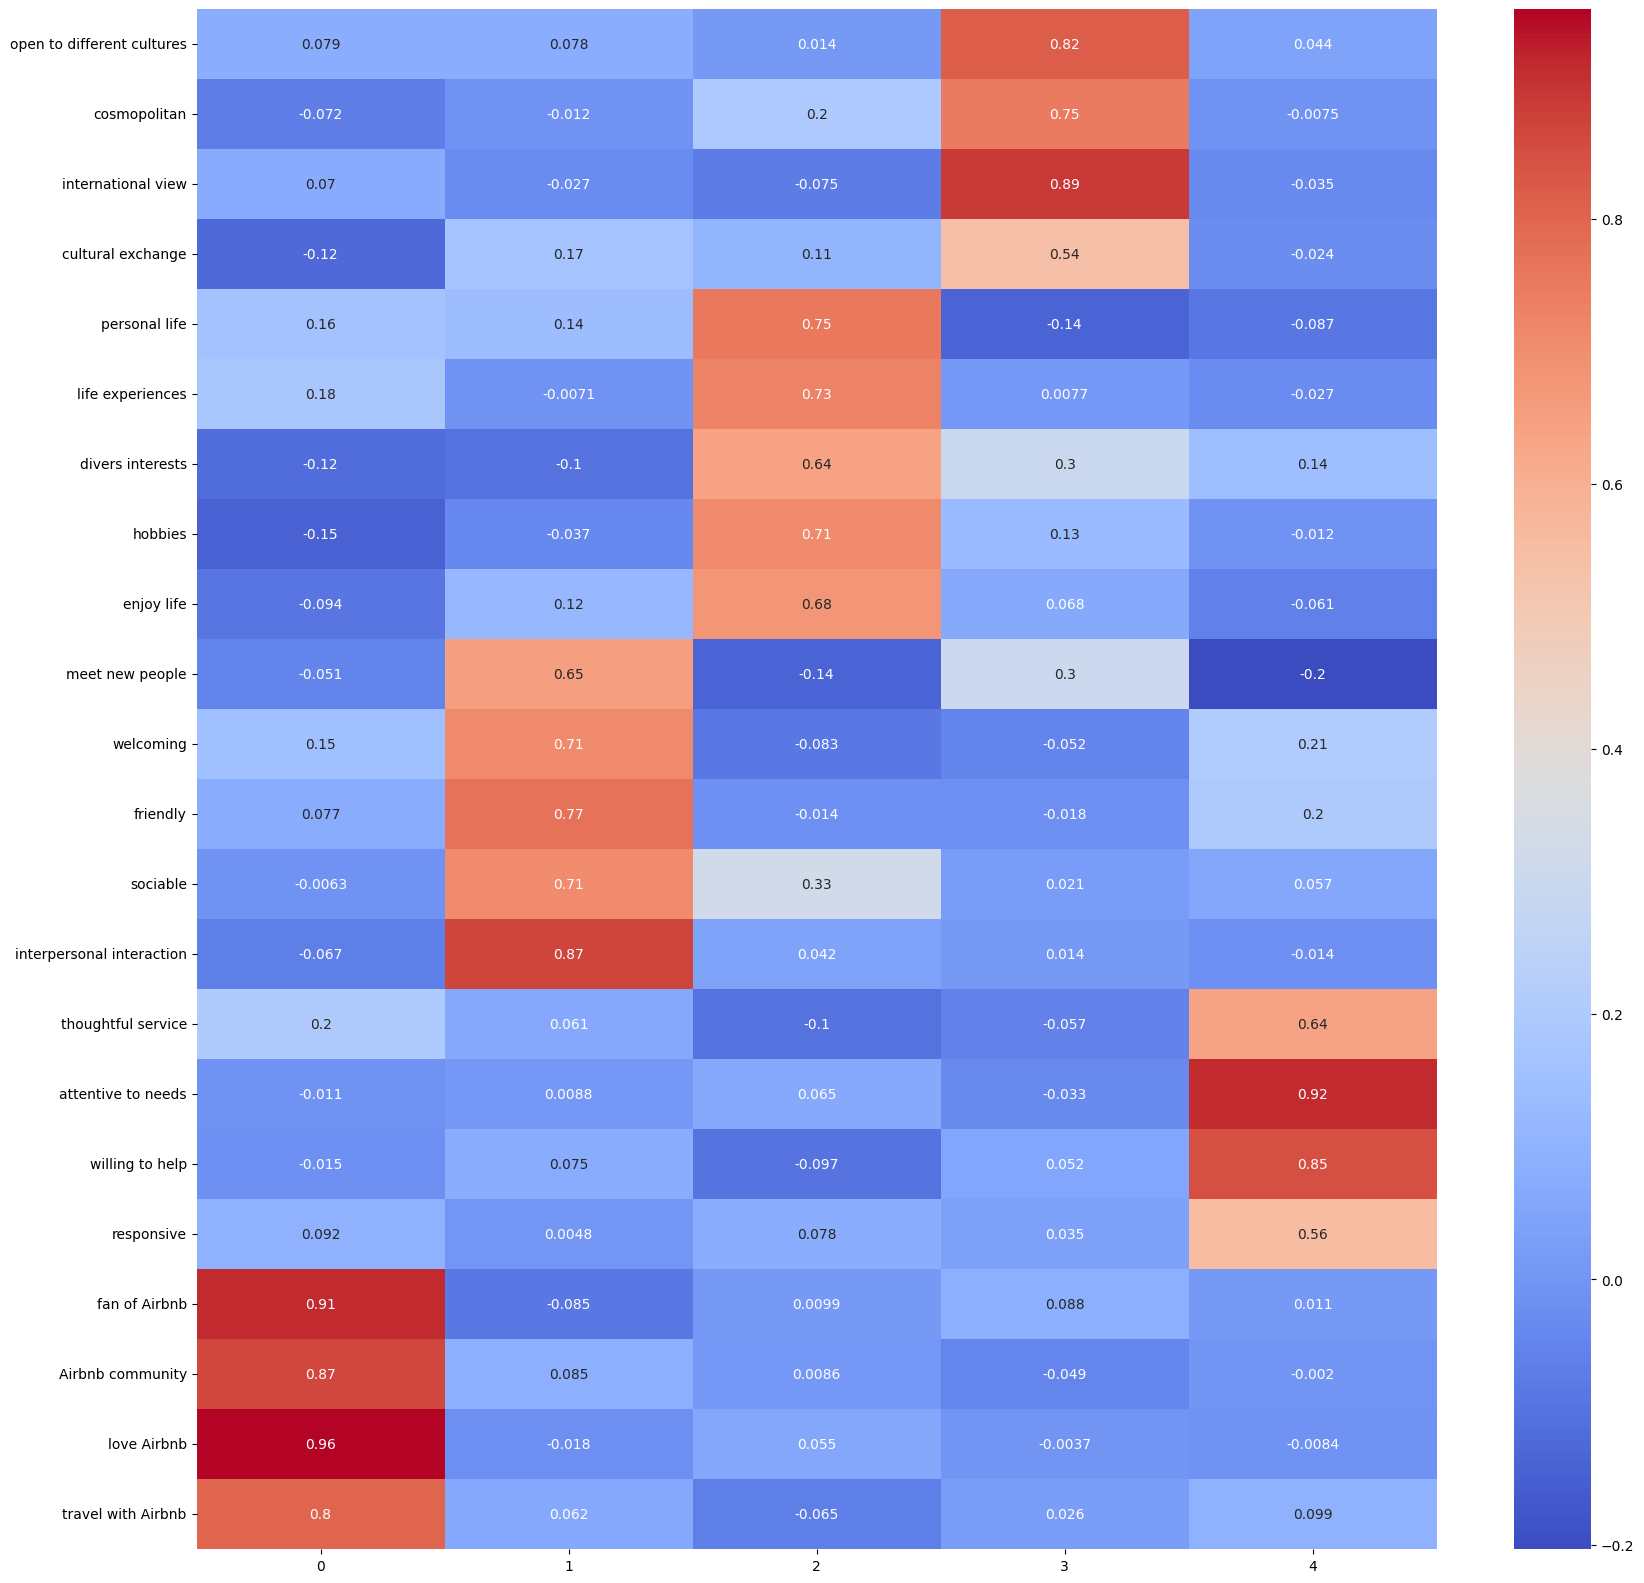

In [ ]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


data=listings[['open to different cultures','cosmopolitan', 'international view', 'cultural exchange',
       'personal life', 'life experiences', 'divers interests', 'hobbies',
       'enjoy life', 'meet new people', 'welcoming', 'friendly', 'sociable','interpersonal interaction', 
       'thoughtful service', 'attentive to needs','willing to help', 'responsive', 
       # 'central location', 'close to attraction', 'close to restaurants','close to transport connections', 'lively neighborhood',
       # 'well-equipped', 'well-decorated', 'cosy place', 'comfortable atmosphere',
       'fan of Airbnb', 'Airbnb community','love Airbnb', 'travel with Airbnb' ]]

print(len(data))
###############去0，去重复值！！！
data=data.dropna()
data=data.drop_duplicates()

print(len(data))

fa=FactorAnalyzer(n_factors=5, rotation='oblimin')
fa.fit(data)
loadings=fa.loadings_
# print(loadings)
loadings_df=pd.DataFrame(loadings,index=data.columns)
# display(loadings_df)

plt.figure(figsize=(20,20))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'ingratiation_open'),
  Text(1, 0, 'ingratiation_honest'),
  Text(2, 0, 'ingratiation_host'),
  Text(3, 0, 'enhancement_host'),
  Text(4, 0, 'exemplification')])

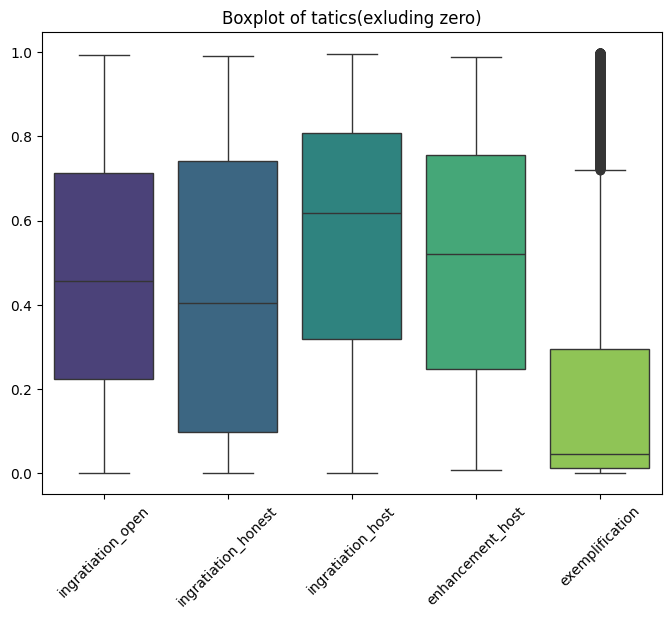

In [ ]:
##在全数据库上！
data=listings[['ingratiation_open', 'ingratiation_honest',
             'ingratiation_host', 'enhancement_host', 'exemplification']].dropna()

plt.figure(figsize=(8,6))
sns.boxplot(data, palette='viridis')
plt.title('Boxplot of tatics(exluding zero)')
plt.xticks(rotation=45)

## cronbash alpha :

In [2]:
listings=pd.read_csv('D:\MASTER_ENC\mini_memoire/res_tactiques2/listings_zsc_tactics6.csv')

In [3]:
from pingouin import cronbach_alpha
labels2tac={
    "ingratiation_open":['open to different cultures','cosmopolitan','international view','cultural exchange'], 
    "ingratiation_honest":['personal life','life experiences','divers interests','hobbies','enjoy life'], 
    'ingratiation_host':['meet new people', 'welcoming', 'friendly','sociable', 'interpersonal interaction',],
    'enhancement_host':['thoughtful service', 'attentive to needs','willing to help','responsive'],
    'exemplification':["fan of Airbnb","Airbnb community",'love Airbnb', 'travel with Airbnb']    
}    

print(len(listings))
for tactic, labels in labels2tac.items():
    alpha, _ = cronbach_alpha(listings[labels])
    print(tactic, alpha)


74329
ingratiation_open 0.8450757368486705
ingratiation_honest 0.8851236592515332
ingratiation_host 0.8679533036440662
enhancement_host 0.8622602975692369
exemplification 0.9338082714271265
